In [195]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
import time
from numpy import newaxis
import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse

In [2]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [70]:
def set_data(stock, seq_len):
    try:
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])

        result = normalise_windows(result)

        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test)
    except:
        print("file" + stock + ".csv not found")


In [4]:
def get_test_data(ticker, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ ticker +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length):
            result.append(seq[index: index + sequence_length])
    
        result = normalise_windows(result)

        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        np.random.shuffle(train)
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        return (x_test, y_test)


    

In [5]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [6]:
def build_model(layers):
    
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))
    model.add(Activation('sigmoid'))
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.4))
    act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    model.add(Dense(
        output_dim=layers[3], activation = 'linear'))
    #model.add(act)

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print("> Compilation Time : ", time.time() - start)
    return model

In [45]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [33]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [34]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [37]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (14,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [15]:
model = build_model([1,100,100,1])

> Compilation Time :  0.009973287582397461


In [13]:
seq_length = 100
epochs = 10
stock_list = set_stock_list()

for stock in stock_list:
    print(stock)
    try:
        x_train,x_test,y_train,y_test = set_data(stock , seq_length)
        model.fit(
            x_train,
            y_train,
            batch_size = 64,
            nb_epoch=epochs,
            validation_data=(x_test, y_test))
    except:
        print("no")

AACG
Train on 2815 samples, validate on 148 samples
Epoch 1/10
2815/2815 [==============================] - 5s 2ms/step - loss: 0.1934 - val_loss: 0.0104
Epoch 2/10
2815/2815 [==============================] - 4s 1ms/step - loss: 0.0414 - val_loss: 0.0116
Epoch 3/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0367 - val_loss: 0.0158
Epoch 4/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0323 - val_loss: 0.0154
Epoch 5/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0296 - val_loss: 0.0079
Epoch 6/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0271 - val_loss: 0.0039
Epoch 7/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0242 - val_loss: 0.0045
Epoch 8/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0246 - val_loss: 0.0055
Epoch 9/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0236 - val_loss: 0.0051
Epoch 10/10
2815/2815 [=======

958/958 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0035
ACER
Train on 505 samples, validate on 27 samples
Epoch 1/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0237
Epoch 2/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0303
Epoch 3/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0263
Epoch 4/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0233
Epoch 5/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0234
Epoch 6/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0247
Epoch 7/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0250
Epoch 8/10
505/505 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0227
Epoch 9/10
505/505 [==============================] - 1s 2ms/

113/113 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0397
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0306
Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0149
Epoch 4/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0065
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0069
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0175
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0350
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0400
Epoch 9/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0291
Epoch 10/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0173
ACTTU
Trai

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0109 - val_loss: 0.0010
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0106 - val_loss: 0.0012
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0102 - val_loss: 0.0019
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0106 - val_loss: 0.0012
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0098 - val_loss: 0.0013
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0094 - val_loss: 0.0015
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0090 - val_loss: 8.8687e-04
ADTN
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0104 - val_loss: 0.0021
Epoch 2/10
4684/4684 [==============

Epoch 9/10
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0283 - val_loss: 0.0025
Epoch 10/10
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0275 - val_loss: 0.0022
AESE
Train on 480 samples, validate on 25 samples
Epoch 1/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0083
Epoch 2/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0084
Epoch 3/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0061
Epoch 4/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0067
Epoch 5/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0057
Epoch 6/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0057
Epoch 7/10
480/480 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0075
Epoch 8/10
480/480 [=========================

Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0169 - val_loss: 0.0135
Epoch 7/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0185
Epoch 8/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 9/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0147
Epoch 10/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0097
AGBA
fileAGBA.csv not found
no
AGBAR
fileAGBAR.csv not found
no
AGBAU
fileAGBAU.csv not found
no
AGBAW
fileAGBAW.csv not found
no
AGEN
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0589 - val_loss: 0.0056
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0485 - val_loss: 0.0051
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0562 - val_loss: 0.0135
Epoch 4/10
4684/4684 

25/25 [==============================] - 0s 5ms/step - loss: 0.0299 - val_loss: 0.0066
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0227 - val_loss: 0.0086
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0137
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0208
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0257
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0302
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss: 0.0287
Epoch 8/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0246
Epoch 9/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 10/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0100
AGNCP
fileAGNCP.csv not found


Epoch 7/10
2859/2859 [==============================] - 4s 2ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 8/10
2859/2859 [==============================] - 4s 2ms/step - loss: 0.0036 - val_loss: 5.8698e-04
Epoch 9/10
2859/2859 [==============================] - 4s 2ms/step - loss: 0.0037 - val_loss: 5.9485e-04
Epoch 10/10
2859/2859 [==============================] - 4s 2ms/step - loss: 0.0034 - val_loss: 8.3982e-04
AIH
Train on 6 samples, validate on 0 samples
Epoch 1/10
no
AIHS
fileAIHS.csv not found
no
AIKI
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5468 - val_loss: 0.0652
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3011 - val_loss: 0.0774
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3951 - val_loss: 0.1463
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3302 - val_loss: 0.0731
Epoch 5/10
4684/4684 [======

Epoch 2/10
97/97 [==============================] - 0s 2ms/step - loss: 2.1342 - val_loss: 0.3339
Epoch 3/10
97/97 [==============================] - 0s 2ms/step - loss: 2.2802 - val_loss: 1.7733
Epoch 4/10
97/97 [==============================] - 0s 2ms/step - loss: 1.9106 - val_loss: 0.6948
Epoch 5/10
97/97 [==============================] - 0s 2ms/step - loss: 2.1642 - val_loss: 1.2052
Epoch 6/10
97/97 [==============================] - 0s 2ms/step - loss: 1.8534 - val_loss: 2.4667
Epoch 7/10
97/97 [==============================] - 0s 2ms/step - loss: 2.1614 - val_loss: 0.1692
Epoch 8/10
97/97 [==============================] - 0s 2ms/step - loss: 1.9098 - val_loss: 0.4432
Epoch 9/10
97/97 [==============================] - 0s 2ms/step - loss: 1.8902 - val_loss: 1.1839
Epoch 10/10
97/97 [==============================] - 0s 2ms/step - loss: 1.6996 - val_loss: 0.4591
AIRTW
Train on 38 samples, validate on 2 samples
Epoch 1/10
38/38 [==============================] - 0s 3ms/step - lo

Epoch 10/10
944/944 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0029
AKTX
fileAKTX.csv not found
no
ALAC
Train on 217 samples, validate on 11 samples
Epoch 1/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 5.1669e-05
Epoch 2/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 3.0450e-04
Epoch 3/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 8.5001e-05
Epoch 4/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 3.2336e-05
Epoch 5/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 4.0153e-05
Epoch 6/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 1.8822e-04
Epoch 7/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 1.4632e-04
Epoch 8/10
217/217 [==============================] - 0s 2ms/step - loss: 0.0023 - val_los

Epoch 6/10
4484/4484 [==============================] - 7s 2ms/step - loss: 0.0176 - val_loss: 0.0040
Epoch 7/10
4484/4484 [==============================] - 7s 2ms/step - loss: 0.0178 - val_loss: 0.0054
Epoch 8/10
4484/4484 [==============================] - 7s 2ms/step - loss: 0.0158 - val_loss: 0.0033
Epoch 9/10
4484/4484 [==============================] - 7s 2ms/step - loss: 0.0157 - val_loss: 0.0048
Epoch 10/10
4484/4484 [==============================] - 7s 2ms/step - loss: 0.0155 - val_loss: 0.0031
ALGR
Train on 287 samples, validate on 15 samples
Epoch 1/10
287/287 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 2/10
287/287 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 3/10
287/287 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 4/10
287/287 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 5/10
287/287 [===================

Epoch 9/10
4494/4494 [==============================] - 7s 2ms/step - loss: 0.0329 - val_loss: 0.0098
Epoch 10/10
4494/4494 [==============================] - 7s 2ms/step - loss: 0.0301 - val_loss: 0.0084
ALSK
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0496 - val_loss: 0.0254
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0430 - val_loss: 0.0106
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0402 - val_loss: 0.0047
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0384 - val_loss: 0.0152
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0363 - val_loss: 0.0205
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0333 - val_loss: 0.0111
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0315 - val_loss: 0.0100
Epoch 8/10
4684/4684 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0077 - val_loss: 0.0045
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0067 - val_loss: 0.0045
AMBA
Train on 1688 samples, validate on 89 samples
Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0147 - val_loss: 0.0051
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0140 - val_loss: 0.0051
Epoch 3/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0132 - val_loss: 0.0051
Epoch 4/10
1688/1688 [===================

2784/2784 [==============================] - 4s 2ms/step - loss: 1.1590 - val_loss: 0.0631
Epoch 2/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.5368 - val_loss: 0.0267
Epoch 3/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.5801 - val_loss: 0.0041
Epoch 4/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.5360 - val_loss: 0.0034
Epoch 5/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.4787 - val_loss: 0.0073
Epoch 6/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.6344 - val_loss: 0.0085
Epoch 7/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.4339 - val_loss: 0.0082
Epoch 8/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.5552 - val_loss: 0.0056
Epoch 9/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.4891 - val_loss: 0.0033
Epoch 10/10
2784/2784 [==============================] - 4s 2ms/step - loss: 0.5680 - val_los

Epoch 2/10
3188/3188 [==============================] - 5s 2ms/step - loss: 1.3232 - val_loss: 0.0087
Epoch 3/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.9706 - val_loss: 0.0158
Epoch 4/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.9488 - val_loss: 0.0135
Epoch 5/10
3188/3188 [==============================] - 5s 2ms/step - loss: 1.3666 - val_loss: 0.0060
Epoch 6/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.8423 - val_loss: 0.0113
Epoch 7/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.8543 - val_loss: 0.0075
Epoch 8/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.9160 - val_loss: 0.0063
Epoch 9/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.9407 - val_loss: 0.0063
Epoch 10/10
3188/3188 [==============================] - 5s 2ms/step - loss: 0.9044 - val_loss: 0.0082
AMWD
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0124 - val_loss: 0.0011
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0105 - val_loss: 0.0012
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0089 - val_loss: 9.3151e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0071 - val_loss: 0.0012
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 9.1614e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 0.0011
ANTE
Train on 2867 samples, validate on 151 samples
Epoch 1/10
2867/2867 [==========

Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 2.5806e-04
Epoch 6/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 5.7960e-06
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 3.7500e-04
Epoch 8/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 9.9167e-04
Epoch 9/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0019
Epoch 10/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0189 - val_loss: 0.0022
APTO
Train on 1203 samples, validate on 63 samples
Epoch 1/10
1203/1203 [==============================] - 2s 2ms/step - loss: 0.0110 - val_loss: 0.0534
Epoch 2/10
1203/1203 [==============================] - 2s 2ms/step - loss: 0.0099 - val_loss: 0.0542
Epoch 3/10
1203/1203 [==============================] - 2s 2ms/step - loss: 0.0101 - val_loss: 0.0520
Epoch 4/10
1203/1203 [================

1019/1019 [==============================] - 2s 2ms/step - loss: 0.0830 - val_loss: 0.0272
Epoch 2/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0548 - val_loss: 0.0061
Epoch 3/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0508 - val_loss: 0.0086
Epoch 4/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0087
Epoch 5/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0415 - val_loss: 0.0123
Epoch 6/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0459 - val_loss: 0.0044
Epoch 7/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0470 - val_loss: 0.0029
Epoch 8/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0374 - val_loss: 0.0258
Epoch 9/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.0022
Epoch 10/10
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0344 - val_los

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0049 - val_loss: 4.2123e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0043 - val_loss: 5.0392e-04
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0042 - val_loss: 3.3386e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 3.7728e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 3.5246e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0039 - val_loss: 3.2898e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0037 - val_loss: 3.7762e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0038 - val_loss: 3.3496e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0035 - val_loss: 3.3221e-04
ARTW
Train on 4684 samples, validate on 247 samples
Epoc

4681/4681 [==============================] - 7s 2ms/step - loss: 0.0647 - val_loss: 0.0018
Epoch 4/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0598 - val_loss: 0.0011
Epoch 5/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0566 - val_loss: 0.0028
Epoch 6/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0575 - val_loss: 0.0013
Epoch 7/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0523 - val_loss: 0.0014
Epoch 8/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0495 - val_loss: 0.0016
Epoch 9/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0468 - val_loss: 0.0037
Epoch 10/10
4681/4681 [==============================] - 7s 2ms/step - loss: 0.0450 - val_loss: 0.0033
ASTC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1794 - val_loss: 0.0339
Epoch 2/10
4684/4684 [==================

1670/1670 [==============================] - 3s 2ms/step - loss: 1.9009 - val_loss: 0.0696
Epoch 6/10
1670/1670 [==============================] - 3s 2ms/step - loss: 1.8928 - val_loss: 0.0889
Epoch 7/10
1670/1670 [==============================] - 3s 2ms/step - loss: 1.9271 - val_loss: 0.0600
Epoch 8/10
1670/1670 [==============================] - 3s 2ms/step - loss: 1.7677 - val_loss: 0.0582
Epoch 9/10
1670/1670 [==============================] - 3s 2ms/step - loss: 1.6515 - val_loss: 0.1038
Epoch 10/10
1670/1670 [==============================] - 3s 2ms/step - loss: 1.7992 - val_loss: 0.1248
ATRA
Train on 1207 samples, validate on 64 samples
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 1.1468 - val_loss: 0.0490
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 1.1260 - val_loss: 0.0550
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 1.1865 - val_loss: 0.0409
Epoch 4/10
1207/1207 [===================

2308/2308 [==============================] - 4s 2ms/step - loss: 0.0995 - val_loss: 0.4384
Epoch 8/10
2308/2308 [==============================] - 4s 2ms/step - loss: 0.1006 - val_loss: 0.4601
Epoch 9/10
2308/2308 [==============================] - 4s 2ms/step - loss: 0.1020 - val_loss: 0.4883
Epoch 10/10
2308/2308 [==============================] - 4s 2ms/step - loss: 0.1026 - val_loss: 0.4650
AVGO
Train on 2450 samples, validate on 129 samples
Epoch 1/10
2450/2450 [==============================] - 4s 2ms/step - loss: 0.0723 - val_loss: 0.0069
Epoch 2/10
2450/2450 [==============================] - 4s 2ms/step - loss: 0.0627 - val_loss: 0.0029
Epoch 3/10
2450/2450 [==============================] - 4s 2ms/step - loss: 0.0669 - val_loss: 0.0179
Epoch 4/10
2450/2450 [==============================] - 4s 2ms/step - loss: 0.0602 - val_loss: 0.0054
Epoch 5/10
2450/2450 [==============================] - 4s 2ms/step - loss: 0.0598 - val_loss: 0.0158
Epoch 6/10
2450/2450 [==================

Epoch 10/10
1290/1290 [==============================] - 2s 2ms/step - loss: 0.0271 - val_loss: 0.0018
AYTU
Train on 651 samples, validate on 34 samples
Epoch 1/10
651/651 [==============================] - 1s 2ms/step - loss: 0.7322 - val_loss: 0.0929
Epoch 2/10
651/651 [==============================] - 1s 2ms/step - loss: 0.8637 - val_loss: 0.1167
Epoch 3/10
651/651 [==============================] - 1s 2ms/step - loss: 0.6977 - val_loss: 0.1012
Epoch 4/10
651/651 [==============================] - 1s 2ms/step - loss: 0.5635 - val_loss: 0.0844
Epoch 5/10
651/651 [==============================] - 1s 2ms/step - loss: 0.6053 - val_loss: 0.1044
Epoch 6/10
651/651 [==============================] - 1s 2ms/step - loss: 0.5418 - val_loss: 0.0920
Epoch 7/10
651/651 [==============================] - 1s 2ms/step - loss: 0.6951 - val_loss: 0.1075
Epoch 8/10
651/651 [==============================] - 1s 2ms/step - loss: 0.5806 - val_loss: 0.0868
Epoch 9/10
651/651 [===========================

Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0203 - val_loss: 0.0109
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0204 - val_loss: 0.0206
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0202 - val_loss: 0.0117
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0199 - val_loss: 0.0102
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0209 - val_loss: 0.0092
BATRA
Train on 849 samples, validate on 45 samples
Epoch 1/10
849/849 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 2/10
849/849 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 3/10
849/849 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 4/10
849/849 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 5/10
849/849 [==================

1843/1843 [==============================] - 3s 2ms/step - loss: 0.0093 - val_loss: 6.9798e-04
Epoch 7/10
1843/1843 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 6.0303e-04
Epoch 8/10
1843/1843 [==============================] - 3s 2ms/step - loss: 0.0085 - val_loss: 5.3621e-04
Epoch 9/10
1843/1843 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 10/10
1843/1843 [==============================] - 3s 2ms/step - loss: 0.0087 - val_loss: 6.2011e-04
BCOW
fileBCOW.csv not found
no
BCPC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0050 - val_loss: 0.0010
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0048 - val_loss: 7.9798e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 7.6627e-04
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0044 - va

3615/3615 [==============================] - 6s 2ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 2/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 5/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 6/10
3615/3615 [==============================] - 5s 2ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 8/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 9/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 10/10
3615/3615 [==============================] - 6s 2ms/step - loss: 0.0034 - val_los

2290/2290 [==============================] - 4s 2ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 3/10
2290/2290 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 4/10
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 5/10
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 6/10
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 7/10
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 8/10
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 9/10
2290/2290 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 10/10
2290/2290 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0022
BICK
Train on 2288 samples, validate on 120 samples
Epoch 1/10
2288/2288 [==================

720/720 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 3/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 4/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 5/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 7/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 8/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 9/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 10/10
720/720 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0043
BLBD
Train on 1341 samples, validate on 71 samples
Epoch 1/10
1341/1341 [==============================] - 2s 

3548/3548 [==============================] - 5s 2ms/step - loss: 0.0098 - val_loss: 0.0894
Epoch 5/10
3548/3548 [==============================] - 5s 2ms/step - loss: 0.0095 - val_loss: 0.0898
Epoch 6/10
3548/3548 [==============================] - 5s 2ms/step - loss: 0.0099 - val_loss: 0.0904
Epoch 7/10
3548/3548 [==============================] - 5s 2ms/step - loss: 0.0095 - val_loss: 0.0916
Epoch 8/10
3548/3548 [==============================] - 5s 2ms/step - loss: 0.0092 - val_loss: 0.0906
Epoch 9/10
3548/3548 [==============================] - 6s 2ms/step - loss: 0.0093 - val_loss: 0.0909
Epoch 10/10
3548/3548 [==============================] - 5s 2ms/step - loss: 0.0090 - val_loss: 0.0901
BMRC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0039 - val_loss: 9.2217e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/10
4684/4684 [==============

Epoch 9/10
267/267 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0145
Epoch 10/10
267/267 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0068
BNGOW
fileBNGOW.csv not found
no
BNSO
Train on 4684 samples, validate on 246 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0086 - val_loss: 0.0017
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0088 - val_loss: 0.0013
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0089 - val_loss: 0.0011
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0087 - val_loss: 0.0011


2618/2618 [==============================] - 4s 2ms/step - loss: 0.0018 - val_loss: 4.3808e-04
BPOPN
fileBPOPN.csv not found
no
BPRN
Train on 793 samples, validate on 42 samples
Epoch 1/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 2/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 3/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 4/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/10
793/793 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/10
793/793 [==

515/515 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0834
Epoch 2/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0862
Epoch 3/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0857
Epoch 4/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0839
Epoch 5/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0832
Epoch 6/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0882
Epoch 7/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0832
Epoch 8/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0837
Epoch 9/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0841
Epoch 10/10
515/515 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0891
BRY
Train 

1191/1191 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0054
Epoch 10/10
1191/1191 [==============================] - 2s 2ms/step - loss: 0.0192 - val_loss: 0.0038
BSJK
Train on 1462 samples, validate on 77 samples
Epoch 1/10
1462/1462 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 6.0712e-05
Epoch 2/10
1462/1462 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 4.4862e-05
Epoch 3/10
1462/1462 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 7.5691e-05
Epoch 4/10
1462/1462 [==============================] - 2s 2ms/step - loss: 9.1443e-04 - val_loss: 4.4710e-05
Epoch 5/10
1462/1462 [==============================] - 2s 2ms/step - loss: 8.5601e-04 - val_loss: 7.4769e-05
Epoch 6/10
1462/1462 [==============================] - 2s 2ms/step - loss: 8.3496e-04 - val_loss: 4.3361e-05
Epoch 7/10
1462/1462 [==============================] - 2s 2ms/step - loss: 8.6220e-04 - val_loss: 4.8137e-

Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 8.1568e-04 - val_loss: 4.5226e-04
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 7.0850e-04 - val_loss: 1.3875e-04
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 4.1959e-04 - val_loss: 2.3506e-05
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 5.7742e-04 - val_loss: 1.0588e-05
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 9.4271e-04 - val_loss: 9.9772e-05
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 6.8939e-04 - val_loss: 4.5389e-04
Epoch 8/10
24/24 [==============================] - 0s 5ms/step - loss: 4.4336e-04 - val_loss: 9.1138e-04
Epoch 9/10
24/24 [==============================] - 0s 5ms/step - loss: 7.7616e-04 - val_loss: 0.0012
Epoch 10/10
24/24 [==============================] - 0s 5ms/step - loss: 7.4129e-04 - val_loss: 8.1029e-04
BSMN
Train on 26 samples, validate on 1 samples
E

BWB
Train on 393 samples, validate on 21 samples
Epoch 1/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0107
Epoch 2/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 4/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 5/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 6/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 7/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 8/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 9/10
393/393 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 10/10
393/393 [==============================

3044/3044 [==============================] - 5s 2ms/step - loss: 90.7566 - val_loss: 0.2656
CAR
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.6097 - val_loss: 0.0098
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.4131 - val_loss: 0.0099
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3359 - val_loss: 0.0077
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3307 - val_loss: 0.0066
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3627 - val_loss: 0.0057
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2622 - val_loss: 0.0034
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2726 - val_loss: 0.0038
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2593 - val_loss: 0.0036
Epoch 9/10
4684/4684 [===================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0093 - val_loss: 3.7211e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0090 - val_loss: 0.0030
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0088 - val_loss: 0.0014
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0085 - val_loss: 4.5368e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0083 - val_loss: 8.5226e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0076 - val_loss: 7.1074e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0079 - val_loss: 4.8774e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0077 - val_loss: 6.9480e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step 

464/464 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0096
Epoch 8/10
464/464 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0094
Epoch 9/10
464/464 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 10/10
464/464 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0091
CBPO
Train on 2815 samples, validate on 148 samples
Epoch 1/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0129 - val_loss: 1.8607e-04
Epoch 2/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0124 - val_loss: 4.7232e-04
Epoch 3/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0121 - val_loss: 1.6828e-04
Epoch 4/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0137 - val_loss: 0.0023
Epoch 5/10
2815/2815 [==============================] - 4s 2ms/step - loss: 0.0130 - val_loss: 1.7039e-04
Epoch 6/10
2815/2815 [==========

Epoch 2/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 3/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 4/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 5/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 6/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 7/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 8/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 9/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 10/10
2005/2005 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0018
CCMP
Train on 4680 samples, validate on 246 samples
Epoch 1/10
4680/4680 [=======

2704/2704 [==============================] - 4s 2ms/step - loss: 0.0304 - val_loss: 0.0023
Epoch 3/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0265 - val_loss: 0.0021
Epoch 4/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0285 - val_loss: 0.0017
Epoch 5/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0274 - val_loss: 0.0019
Epoch 6/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0258 - val_loss: 0.0027
Epoch 7/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0277 - val_loss: 0.0018
Epoch 8/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0291 - val_loss: 0.0018
Epoch 9/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0261 - val_loss: 0.0019
Epoch 10/10
2704/2704 [==============================] - 4s 2ms/step - loss: 0.0240 - val_loss: 0.0018
CDXS
Train on 2281 samples, validate on 120 samples
Epoch 1/10
2281/2281 [==================

Epoch 4/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/10
483/483 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0016
CEZ
Train on 864 samples, validate on 46 samples
Epoch 1/10
864/864 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 2/10
864/864 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/10
864/864 [==============================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0044 - val_loss: 9.2879e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0045 - val_loss: 9.8616e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0042 - val_loss: 9.9677e-04
CGO
Train on 3352 samples, validate on 176 samples
Epoch 1/10
3352/3352 [==============================] - 5s 2ms/step - loss: 0.0020 - val_loss: 8.9497e-04
Epoch 2/10
3352/3352 [==============================] - 5s 2ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/10
3352/3352 [===

Epoch 4/10
1149/1149 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 9.7435e-04
Epoch 5/10
1149/1149 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/10
1149/1149 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 9.8302e-04
Epoch 7/10
1149/1149 [==============================] - 2s 2ms/step - loss: 9.2879e-04 - val_loss: 0.0010
Epoch 8/10
1149/1149 [==============================] - 2s 2ms/step - loss: 8.7414e-04 - val_loss: 9.9586e-04
Epoch 9/10
1149/1149 [==============================] - 2s 2ms/step - loss: 8.7711e-04 - val_loss: 0.0010
Epoch 10/10
1149/1149 [==============================] - 2s 2ms/step - loss: 8.5117e-04 - val_loss: 0.0011
CHSCM
Train on 1228 samples, validate on 65 samples
Epoch 1/10
1228/1228 [==============================] - 2s 2ms/step - loss: 9.0958e-04 - val_loss: 0.0019
Epoch 2/10
1228/1228 [==============================] - 2s 2ms/step - loss: 9.0148e-04 - val_loss: 

Epoch 10/10
1004/1004 [==============================] - 2s 2ms/step - loss: 3.9482e-04 - val_loss: 8.1536e-04
CINF
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.9954e-04 - val_loss: 7.4568e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.8333e-04 - val_loss: 8.4386e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.8267e-04 - val_loss: 0.0011
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.9251e-04 - val_loss: 7.0207e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.5122e-04 - val_loss: 0.0011
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.4641e-04 - val_loss: 6.3807e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.7411e-04 - val_loss: 6.0363e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss:

4684/4684 [==============================] - 7s 2ms/step - loss: 0.3595 - val_loss: 0.0103
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3213 - val_loss: 0.0080
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3123 - val_loss: 0.0035
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3067 - val_loss: 0.0131
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2971 - val_loss: 0.0053
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2616 - val_loss: 0.0029
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2661 - val_loss: 0.0063
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2913 - val_loss: 0.0073
CLCT
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0193 - val_loss: 0.0019
Epoch 2/10
4684/4684 [==================

2976/2976 [==============================] - 5s 2ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 10/10
2976/2976 [==============================] - 5s 2ms/step - loss: 0.0054 - val_loss: 0.0023
CLOU
Train on 133 samples, validate on 7 samples
Epoch 1/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.6362e-04
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.4854e-04
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 7.2096e-04
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/10
133/133 [=========================

234/234 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 4.6734e-04
Epoch 2/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 1.0160e-04
Epoch 3/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.1584e-04
Epoch 5/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 1.2638e-04
Epoch 6/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.7956e-04
Epoch 8/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 3.9424e-04
Epoch 9/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.4455e-04
Epoch 10/10
234/234 [==============================] - 0s 2ms/step - loss: 0.0015 -

Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 7.1242e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 9.0319e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0027 - val_loss: 8.5710e-04
CNCE
Train on 1369 samples, validate on 72 samples
Epoch 1/10
1369/1369 [==============================] - 2s 2ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 2/10
1369/1369 [==============================] - 2s 2ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 3/10
1369/1369 [==============================] - 2s 2ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 4/10
1369/1369 [==============================] - 2s 2ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 5/10
1369/1369 [==============================] - 2s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 6/10
1369/13

Epoch 3/10
310/310 [==============================] - 1s 2ms/step - loss: 0.2033 - val_loss: 0.1941
Epoch 4/10
310/310 [==============================] - 1s 2ms/step - loss: 0.2149 - val_loss: 0.0920
Epoch 5/10
310/310 [==============================] - 0s 2ms/step - loss: 0.1963 - val_loss: 0.1151
Epoch 6/10
310/310 [==============================] - 1s 2ms/step - loss: 0.1790 - val_loss: 0.0696
Epoch 7/10
310/310 [==============================] - 0s 2ms/step - loss: 0.1558 - val_loss: 0.0512
Epoch 8/10
310/310 [==============================] - 0s 2ms/step - loss: 0.1457 - val_loss: 0.1043
Epoch 9/10
310/310 [==============================] - 1s 2ms/step - loss: 0.1468 - val_loss: 0.0861
Epoch 10/10
310/310 [==============================] - 1s 2ms/step - loss: 0.1384 - val_loss: 0.0672
CNTG
fileCNTG.csv not found
no
CNTY
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0103 - val_loss: 0.0030
Epoch 2/10
468

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0030 - val_loss: 0.0038
COLB
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0033 - val_loss: 9.9965e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0033 - val_loss: 9.4889e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 8/10
4684/4684 [==========

280/280 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 4.8352e-04
CPAAW
Train on 141 samples, validate on 7 samples
Epoch 1/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0028
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0036
Epoch 5/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0048
Epoch 7/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 8/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0065
Epoch 9/10
141/141 [==============================] - 0s 

Epoch 6/10
4175/4175 [==============================] - 6s 2ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/10
4175/4175 [==============================] - 6s 2ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/10
4175/4175 [==============================] - 6s 2ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/10
4175/4175 [==============================] - 6s 2ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 10/10
4175/4175 [==============================] - 6s 2ms/step - loss: 0.0019 - val_loss: 0.0011
CPSS
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0075 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0080 - val_loss: 0.0019
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 5/10
4684/4684 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 9/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_los

3845/3845 [==============================] - 6s 2ms/step - loss: 0.0118 - val_loss: 9.2168e-04
Epoch 4/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0165 - val_loss: 0.0016
Epoch 5/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0147 - val_loss: 0.0016
Epoch 6/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0148 - val_loss: 0.0050
Epoch 7/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0121 - val_loss: 0.0022
Epoch 8/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0136 - val_loss: 0.0015
Epoch 9/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0142 - val_loss: 0.0034
Epoch 10/10
3845/3845 [==============================] - 6s 2ms/step - loss: 0.0149 - val_loss: 0.0011
CSA
fileCSA.csv not found
no
CSB
Train on 1035 samples, validate on 54 samples
Epoch 1/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/1

Epoch 3/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0022
Epoch 4/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0122
Epoch 5/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.0097
Epoch 6/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0057
Epoch 7/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0368
Epoch 8/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0044
Epoch 9/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 10/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0132
CSTR
fileCSTR.csv not found
no
CSWC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0052 - val_loss: 8.8051e-04
Epoch 2/10
4684/4684 [====

Epoch 3/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.0059
Epoch 4/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.9277 - val_loss: 0.0063
Epoch 5/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.5157 - val_loss: 0.0063
Epoch 6/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.4634 - val_loss: 0.0056
Epoch 7/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.3307 - val_loss: 0.0061
Epoch 8/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.2110 - val_loss: 0.0058
Epoch 9/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.3185 - val_loss: 0.0058
Epoch 10/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.2473 - val_loss: 0.0069
CTXR
fileCTXR.csv not found
no
CTXRW
Train on 210 samples, validate on 11 samples
Epoch 1/10
210/210 [==============================] - 0s 2ms/step - loss: 0.3928 - val_loss: 0.0781
E

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 4.9804e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 9.4559e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 5.8529e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0022 - val_loss: 6.8315e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 7.9028e-04
CWBR
fileCWBR.csv not found
no
CWCO
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0025 - val_lo

4684/4684 [==============================] - 7s 2ms/step - loss: 4.8949 - val_loss: 0.3751
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 4.6276 - val_loss: 0.3500
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 4.3439 - val_loss: 0.2713
CYBR
Train on 1223 samples, validate on 64 samples
Epoch 1/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.1102 - val_loss: 0.1552
Epoch 2/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.2415 - val_loss: 0.1856
Epoch 3/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.0684 - val_loss: 0.1973
Epoch 4/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.0507 - val_loss: 0.1870
Epoch 5/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.0624 - val_loss: 0.1638
Epoch 6/10
1223/1223 [==============================] - 2s 2ms/step - loss: 4.0039 - val_loss: 0.1412
Epoch 7/10
1223/1223 [===================

3711/3711 [==============================] - 6s 2ms/step - loss: 1.0875 - val_loss: 0.0541
Epoch 5/10
3711/3711 [==============================] - 6s 2ms/step - loss: 1.1677 - val_loss: 0.0538
Epoch 6/10
3711/3711 [==============================] - 6s 1ms/step - loss: 1.2002 - val_loss: 0.0600
Epoch 7/10
3711/3711 [==============================] - 6s 1ms/step - loss: 1.4354 - val_loss: 0.0667
Epoch 8/10
3711/3711 [==============================] - 6s 1ms/step - loss: 1.2300 - val_loss: 0.0600
Epoch 9/10
3711/3711 [==============================] - 6s 2ms/step - loss: 1.1744 - val_loss: 0.0655
Epoch 10/10
3711/3711 [==============================] - 6s 2ms/step - loss: 1.1938 - val_loss: 0.0602
CZNC
fileCZNC.csv not found
no
CZR
Train on 1850 samples, validate on 97 samples
Epoch 1/10
1850/1850 [==============================] - 3s 2ms/step - loss: 0.4788 - val_loss: 0.0610
Epoch 2/10
1850/1850 [==============================] - 3s 2ms/step - loss: 0.4826 - val_loss: 0.0618
Epoch 3/10


86/86 [==============================] - 0s 2ms/step - loss: 59484.8084 - val_loss: 57110.7539
Epoch 7/10
86/86 [==============================] - 0s 2ms/step - loss: 57682.5056 - val_loss: 56921.1250
Epoch 8/10
86/86 [==============================] - 0s 2ms/step - loss: 57509.2183 - val_loss: 56727.3594
Epoch 9/10
86/86 [==============================] - 0s 2ms/step - loss: 55156.0700 - val_loss: 56560.4766
Epoch 10/10
86/86 [==============================] - 0s 2ms/step - loss: 55129.9405 - val_loss: 56430.8594
DEACW
fileDEACW.csv not found
no
DENN
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 52806.6105 - val_loss: 48277.2948
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 45724.3492 - val_loss: 42414.6532
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 39411.2478 - val_loss: 32146.9967
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/st

Epoch 6/10
3426/3426 [==============================] - 5s 2ms/step - loss: 0.1993 - val_loss: 0.0191
Epoch 7/10
3426/3426 [==============================] - 5s 2ms/step - loss: 0.2058 - val_loss: 0.0183
Epoch 8/10
3426/3426 [==============================] - 5s 2ms/step - loss: 0.2006 - val_loss: 0.0214
Epoch 9/10
3426/3426 [==============================] - 5s 2ms/step - loss: 0.2029 - val_loss: 0.0195
Epoch 10/10
3426/3426 [==============================] - 5s 2ms/step - loss: 0.1979 - val_loss: 0.0180
DISCB
Train on 3337 samples, validate on 176 samples
Epoch 1/10
3337/3337 [==============================] - 5s 2ms/step - loss: 0.1997 - val_loss: 0.0152
Epoch 2/10
3337/3337 [==============================] - 5s 2ms/step - loss: 0.1957 - val_loss: 0.0148
Epoch 3/10
3337/3337 [==============================] - 5s 2ms/step - loss: 0.1973 - val_loss: 0.0165
Epoch 4/10
3337/3337 [==============================] - 5s 2ms/step - loss: 0.2001 - val_loss: 0.0159
Epoch 5/10
3337/3337 [======

Epoch 9/10
364/364 [==============================] - 1s 2ms/step - loss: 0.1122 - val_loss: 0.0053
Epoch 10/10
364/364 [==============================] - 1s 2ms/step - loss: 0.0972 - val_loss: 0.0053
DOGZ
Train on 447 samples, validate on 24 samples
Epoch 1/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1605 - val_loss: 0.1369
Epoch 2/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1485 - val_loss: 0.0778
Epoch 3/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1351 - val_loss: 0.0613
Epoch 4/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1263 - val_loss: 0.0555
Epoch 5/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1396 - val_loss: 0.0474
Epoch 6/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1223 - val_loss: 0.0419
Epoch 7/10
447/447 [==============================] - 1s 2ms/step - loss: 0.1241 - val_loss: 0.0388
Epoch 8/10
447/447 [=============================

Epoch 6/10
3683/3683 [==============================] - 6s 2ms/step - loss: 0.1753 - val_loss: 41.1464
Epoch 7/10
3683/3683 [==============================] - 6s 2ms/step - loss: 0.1516 - val_loss: 41.0982
Epoch 8/10
3683/3683 [==============================] - 6s 2ms/step - loss: 0.1523 - val_loss: 41.0205
Epoch 9/10
3683/3683 [==============================] - 6s 2ms/step - loss: 0.1500 - val_loss: 37.7619
Epoch 10/10
3683/3683 [==============================] - 6s 2ms/step - loss: 0.1520 - val_loss: 37.7138
DRADP
fileDRADP.csv not found
no
DRIO
Train on 1215 samples, validate on 64 samples
Epoch 1/10
1215/1215 [==============================] - 2s 1ms/step - loss: 8.9530 - val_loss: 230.7954
Epoch 2/10
1215/1215 [==============================] - 2s 1ms/step - loss: 8.3623 - val_loss: 209.5585
Epoch 3/10
1215/1215 [==============================] - 2s 2ms/step - loss: 5.2527 - val_loss: 217.6251
Epoch 4/10
1215/1215 [==============================] - 2s 2ms/step - loss: 4.8567 - val

3757/3757 [==============================] - 6s 2ms/step - loss: 0.4002 - val_loss: 0.0182
Epoch 8/10
3757/3757 [==============================] - 6s 2ms/step - loss: 0.3624 - val_loss: 0.0192
Epoch 9/10
3757/3757 [==============================] - 6s 2ms/step - loss: 0.4547 - val_loss: 0.0196
Epoch 10/10
3757/3757 [==============================] - 6s 2ms/step - loss: 0.4344 - val_loss: 0.0236
DVLU
Train on 274 samples, validate on 14 samples
Epoch 1/10
274/274 [==============================] - 1s 2ms/step - loss: 0.0618 - val_loss: 0.0293
Epoch 2/10
274/274 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0229
Epoch 3/10
274/274 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0182
Epoch 4/10
274/274 [==============================] - 1s 2ms/step - loss: 0.0523 - val_loss: 0.0192
Epoch 5/10
274/274 [==============================] - 1s 2ms/step - loss: 0.0483 - val_loss: 0.0234
Epoch 6/10
274/274 [==============================] 

Epoch 3/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0236 - val_loss: 0.0035
Epoch 4/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0230 - val_loss: 0.0037
Epoch 5/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0233 - val_loss: 0.0040
Epoch 6/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0232 - val_loss: 0.0039
Epoch 7/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0236 - val_loss: 0.0038
Epoch 8/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0225 - val_loss: 0.0037
Epoch 9/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0214 - val_loss: 0.0041
Epoch 10/10
1715/1715 [==============================] - 3s 2ms/step - loss: 0.0202 - val_loss: 0.0048
DWSH
Train on 315 samples, validate on 17 samples
Epoch 1/10
315/315 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0701
Epoch 2/10
315/315 [=============

220/220 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 5/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 6/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 7/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 8/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 9/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 10/10
220/220 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0045
EBMT
Train on 4679 samples, validate on 246 samples
Epoch 1/10
4679/4679 [==============================] - 7s 2ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 2/10
4679/4679 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 9.5074e-04
Epoch 3/10
4679/4679 [============================

4684/4684 [==============================] - 7s 2ms/step - loss: 8.4463 - val_loss: 0.0190
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.5845 - val_loss: 0.0321
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.5737 - val_loss: 0.0331
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 8.2112 - val_loss: 0.0266
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.2454 - val_loss: 0.0263
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.7341 - val_loss: 0.0589
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.8922 - val_loss: 0.0219
EFSC
Train on 3901 samples, validate on 205 samples
Epoch 1/10
3901/3901 [==============================] - 6s 2ms/step - loss: 0.0916 - val_loss: 0.0058
Epoch 2/10
3901/3901 [==============================] - 6s 2ms/step - loss: 0.0588 - val_loss: 0.0072
Epoch 3/10
3901/3901 [==================

Epoch 10/10
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0041
EIGR
Train on 1378 samples, validate on 73 samples
Epoch 1/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.8916 - val_loss: 0.0071
Epoch 2/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.3214 - val_loss: 0.0390
Epoch 3/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.1935 - val_loss: 0.0145
Epoch 4/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.1119 - val_loss: 0.0097
Epoch 5/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.2151 - val_loss: 0.0071
Epoch 6/10
1378/1378 [==============================] - 2s 2ms/step - loss: 0.9486 - val_loss: 0.0119
Epoch 7/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.0281 - val_loss: 0.0045
Epoch 8/10
1378/1378 [==============================] - 2s 2ms/step - loss: 1.1386 - val_loss: 0.0052
Epoch 9/10
1378/1378 [========

Train on 1138 samples, validate on 60 samples
Epoch 1/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0449 - val_loss: 0.0025
Epoch 2/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0330 - val_loss: 0.0032
Epoch 3/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0326 - val_loss: 0.0040
Epoch 4/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0288 - val_loss: 0.0025
Epoch 5/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0277 - val_loss: 0.0028
Epoch 6/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0272 - val_loss: 0.0027
Epoch 7/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0287 - val_loss: 0.0027
Epoch 8/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0259 - val_loss: 0.0027
Epoch 9/10
1138/1138 [==============================] - 2s 2ms/step - loss: 0.0270 - val_loss: 0.0026
Epoch 10/10
1138/1138 [=============

1225/1225 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 4/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 5/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0052 - val_loss: 0.0109
Epoch 6/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.0119
Epoch 7/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0054 - val_loss: 0.0119
Epoch 8/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0046 - val_loss: 0.0118
Epoch 9/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 10/10
1225/1225 [==============================] - 2s 2ms/step - loss: 0.0046 - val_loss: 0.0103
ERIC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0965 - val_loss: 7.9841e-04
Epoch 2/10
4684/4684 [==============

Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
ESGE
Train on 788 samples, validate on 41 samples
Epoch 1/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 2/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 3/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 4/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 5/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 6/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/10
788/788 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 8/10
788/788 [=============================

749/749 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0077
Epoch 10/10
749/749 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0089
EVER
Train on 323 samples, validate on 17 samples
Epoch 1/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0496 - val_loss: 0.0203
Epoch 2/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0618 - val_loss: 0.0453
Epoch 3/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0524 - val_loss: 0.0248
Epoch 4/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0616 - val_loss: 0.0496
Epoch 5/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0375
Epoch 6/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0408 - val_loss: 0.0311
Epoch 7/10
323/323 [==============================] - 1s 2ms/step - loss: 0.0865 - val_loss: 0.0722
Epoch 8/10
323/323 [==============================] - 1s 2ms

347/347 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 6/10
347/347 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/10
347/347 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 8/10
347/347 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 9/10
347/347 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 10/10
347/347 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0037
EVSI
Train on 2274 samples, validate on 120 samples
Epoch 1/10
2274/2274 [==============================] - 3s 2ms/step - loss: 3.1986 - val_loss: 0.0207
Epoch 2/10
2274/2274 [==============================] - 3s 1ms/step - loss: 1.4324 - val_loss: 0.0157
Epoch 3/10
2274/2274 [==============================] - 3s 1ms/step - loss: 1.6620 - val_loss: 0.0178
Epoch 4/10
2274/2274 [==============================

Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 10/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0059 - val_loss: 0.0022
EYE
Train on 999 samples, validate on 53 samples
Epoch 1/10
999/999 [==============================] - 2s 2ms/step - loss: 0.3728 - val_loss: 0.0210
Epoch 2/10
999/999 [==============================] - 2s 2ms/step - loss: 0.2871 - val_loss: 0.0665
Epoch 3/10
999/999 [==============================] - 2s 2ms/step - loss: 0.2316 - val_loss: 0.0173
Epoch 4/10
999/999 [==================

2978/2978 [==============================] - 5s 2ms/step - loss: 0.0028 - val_loss: 5.4282e-04
Epoch 2/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0024 - val_loss: 5.3678e-04
Epoch 3/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0023 - val_loss: 6.3420e-04
Epoch 4/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0024 - val_loss: 7.1178e-04
Epoch 5/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 5.6358e-04
Epoch 6/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 5.9852e-04
Epoch 7/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0023 - val_loss: 5.9585e-04
Epoch 8/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 5.6219e-04
Epoch 9/10
2978/2978 [==============================] - 5s 2ms/step - loss: 0.0022 - val_loss: 5.8940e-04
Epoch 10/10
2978/2978 [==============================] - 

Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 0.0030
FAT
Train on 485 samples, validate on 26 samples
Epoch 1/10
485/485 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 2/10
485/485 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 3/10
485/485 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 4/10
485/485 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/10
485/485 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 6/10
485/485 [======================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss: 7.3830e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss: 4.3562e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss: 4.5406e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 5.8968e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 5.3932e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss: 6.0772e-04
FCCY
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0018 - val_loss: 6.7822e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0017 - val_loss: 8.0140e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0018 - val_loss: 7.0040e-04
Epoc

Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0031 - val_loss: 7.5593e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0029 - val_loss: 8.8171e-04
FDIV
fileFDIV.csv not found
no
FDNI
Train on 232 samples, validate on 12 samples
Epoch 1/10
232/232 [==============================] - 0s 2ms/step - loss: 7.0893e-04 - val_loss: 0.0022
Epoch 2/10
232/232 [==============================] - 0s 2ms/step - loss: 7.8573e-04 - val_loss: 0.0023
Epoch 3/10
232/232 [==============================] - 0s 2ms/step - loss: 6.9509e-04 - val_loss: 0.0023
Epoch 4/10
232/232 [==============================] - 0s 2ms/step - loss: 7.4132e-04 - val_loss: 0.0022
Epoch 5/10
232/232 [==============================] - 0s 2ms/step - loss: 7.0680e-04 - val_loss: 0.0022
Epoch 6/10
232/232 [==============================] - 0s 2ms/step - loss: 9.0886e-04 - val_loss: 0.0023
Epoch 7/10
232/232 [==============================] - 0s 2ms/step - loss: 7.0729e-

Epoch 5/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 6/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 7/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 8/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 9/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 10/10
1464/1464 [==============================] - 2s 2ms/step - loss: 0.0035 - val_loss: 0.0033
FFBC
fileFFBC.csv not found
no
FFBW
Train on 490 samples, validate on 26 samples
Epoch 1/10
490/490 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2/10
490/490 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 3/10
490/490 [==============================] - 1s 2ms/step - loss: 7.4441e-04 - val_loss: 0.0027
Ep

4502/4502 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss: 9.5491e-04
FGEN
Train on 1188 samples, validate on 62 samples
Epoch 1/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 2/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 3/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 5/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 7/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 8/10
1188/1188 [==============================] - 2s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 9/10
1188/1188 [================

4684/4684 [==============================] - 7s 1ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0030 - val_loss: 8.2745e-04
FJP
Train on 2039 samples, validate on 107 samples
Epoch 1/10
2039/2039 [==============================] - 3s 1ms/step - loss: 5.1287e-04 - val_loss: 2.9181e-04
Epoch 2/10
2039/2039 [==============================] - 3s 1ms/step - loss: 4.3086e-04 - val_loss: 3.1082e-04
Epoch 3/10
2039/2039 [==============================] - 3s 1ms/step - loss: 4.3552e-04 - val_loss: 3.6484e-04
Epoch 4/10
2039/2039 [==============================] - 3s 1ms/step - loss: 4.1148e-04 - val_loss: 3.3925e-04
Epoch 5/10
2039/2039 [==============================] - 3s 2ms/step - loss: 4.2430e-04 - val_loss: 3.6289e-04
Epoch 6/10
2039/2039 [==============================] - 3s 1ms/step - loss: 3.7852e-04 - val_loss: 3.7235e-04
Epoch 7/10
2039/2039 [==============================] - 3s 2ms/step - loss: 3.6567e-04 - va

1309/1309 [==============================] - 2s 2ms/step - loss: 3.3041e-04 - val_loss: 1.3099e-04
Epoch 8/10
1309/1309 [==============================] - 2s 2ms/step - loss: 2.8904e-04 - val_loss: 1.6890e-04
Epoch 9/10
1309/1309 [==============================] - 2s 2ms/step - loss: 3.2000e-04 - val_loss: 1.2498e-04
Epoch 10/10
1309/1309 [==============================] - 2s 2ms/step - loss: 3.0066e-04 - val_loss: 1.4865e-04
FMBH
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 4.5706e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 4.2171e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 4.4419e-04
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0012 - val_loss: 4.1198e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0013 - val_loss:

Epoch 6/10
305/305 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0305
Epoch 7/10
305/305 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0309
Epoch 8/10
305/305 [==============================] - 1s 2ms/step - loss: 0.0688 - val_loss: 0.0304
Epoch 9/10
305/305 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0297
Epoch 10/10
305/305 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0294
FOLD
Train on 2974 samples, validate on 156 samples
Epoch 1/10
2974/2974 [==============================] - 5s 2ms/step - loss: 0.1390 - val_loss: 0.0100
Epoch 2/10
2974/2974 [==============================] - 5s 2ms/step - loss: 0.1118 - val_loss: 0.0048
Epoch 3/10
2974/2974 [==============================] - 5s 2ms/step - loss: 0.1048 - val_loss: 0.0036
Epoch 4/10
2974/2974 [==============================] - 5s 2ms/step - loss: 0.0986 - val_loss: 0.0035
Epoch 5/10
2974/2974 [=================

Epoch 2/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 3/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 4/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 5/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 6/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 7/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 8/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0096
Epoch 9/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0104
Epoch 10/10
156/156 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0112
FOXA
fileFOXA.csv not found
no
FOXF
Train on 1492 samples, validate on 79 samples
Epoch 1/10
1492/1

1192/1192 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 5/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 6/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 7/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 8/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 9/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 10/10
1192/1192 [==============================] - 2s 2ms/step - loss: 0.0062 - val_loss: 0.0069
FRSX
fileFRSX.csv not found
no
FRTA
Train on 726 samples, validate on 38 samples
Epoch 1/10
726/726 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0368
Epoch 2/10
726/726 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0298
Epoch 3/10
726/

Epoch 2/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.4223e-04 - val_loss: 3.9856e-04
Epoch 3/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.7320e-04 - val_loss: 3.8709e-04
Epoch 4/10
3185/3185 [==============================] - 5s 2ms/step - loss: 7.0548e-04 - val_loss: 3.8669e-04
Epoch 5/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.4031e-04 - val_loss: 4.4357e-04
Epoch 6/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.9807e-04 - val_loss: 3.9004e-04
Epoch 7/10
3185/3185 [==============================] - 5s 2ms/step - loss: 7.1245e-04 - val_loss: 3.7353e-04
Epoch 8/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.2950e-04 - val_loss: 3.8827e-04
Epoch 9/10
3185/3185 [==============================] - 5s 2ms/step - loss: 7.2036e-04 - val_loss: 3.7639e-04
Epoch 10/10
3185/3185 [==============================] - 5s 2ms/step - loss: 6.5027e-04 - val_loss: 3.9174e-04
FTDR
Trai

734/734 [==============================] - 1s 2ms/step - loss: 105.8619 - val_loss: 2.5887
Epoch 2/10
734/734 [==============================] - 1s 2ms/step - loss: 116.5614 - val_loss: 2.4454
Epoch 3/10
734/734 [==============================] - 1s 2ms/step - loss: 109.1903 - val_loss: 1.8466
Epoch 4/10
734/734 [==============================] - 1s 2ms/step - loss: 110.3520 - val_loss: 0.9899
Epoch 5/10
734/734 [==============================] - 1s 2ms/step - loss: 120.7970 - val_loss: 1.5387
Epoch 6/10
734/734 [==============================] - 1s 2ms/step - loss: 112.0431 - val_loss: 4.4857
Epoch 7/10
734/734 [==============================] - 1s 2ms/step - loss: 120.9663 - val_loss: 2.2861
Epoch 8/10
734/734 [==============================] - 1s 2ms/step - loss: 108.6293 - val_loss: 2.0194
Epoch 9/10
734/734 [==============================] - 1s 2ms/step - loss: 126.5204 - val_loss: 0.7635
Epoch 10/10
734/734 [==============================] - 1s 2ms/step - loss: 111.5084 - val_los

2042/2042 [==============================] - 3s 2ms/step - loss: 3.3666 - val_loss: 0.0228
Epoch 3/10
2042/2042 [==============================] - 3s 2ms/step - loss: 3.2321 - val_loss: 0.0224
Epoch 4/10
2042/2042 [==============================] - 3s 1ms/step - loss: 3.1569 - val_loss: 0.0403
Epoch 5/10
2042/2042 [==============================] - 3s 2ms/step - loss: 3.0982 - val_loss: 0.0395
Epoch 6/10
2042/2042 [==============================] - 3s 2ms/step - loss: 2.7826 - val_loss: 0.0159
Epoch 7/10
2042/2042 [==============================] - 3s 2ms/step - loss: 2.7643 - val_loss: 0.0176
Epoch 8/10
2042/2042 [==============================] - 3s 2ms/step - loss: 2.7190 - val_loss: 0.0199
Epoch 9/10
2042/2042 [==============================] - 3s 2ms/step - loss: 2.6652 - val_loss: 0.0139
Epoch 10/10
2042/2042 [==============================] - 3s 2ms/step - loss: 2.2459 - val_loss: 0.0229
FYT
Train on 2042 samples, validate on 107 samples
Epoch 1/10
2042/2042 [===================

717/717 [==============================] - 1s 2ms/step - loss: 0.2169 - val_loss: 0.0088
Epoch 4/10
717/717 [==============================] - 1s 2ms/step - loss: 0.2001 - val_loss: 0.0086
Epoch 5/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1930 - val_loss: 0.0084
Epoch 6/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1794 - val_loss: 0.0093
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1799 - val_loss: 0.0213
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1685 - val_loss: 0.0093
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1787 - val_loss: 0.0079
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.1657 - val_loss: 0.0098
GDYN
Train on 238 samples, validate on 13 samples
Epoch 1/10
238/238 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0635
Epoch 2/10
238/238 [==============================] - 0s 2ms

Train on 766 samples, validate on 40 samples
Epoch 1/10
766/766 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0140
Epoch 2/10
766/766 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0146
Epoch 3/10
766/766 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0140
Epoch 4/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0145
Epoch 5/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0317 - val_loss: 0.0141
Epoch 6/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0141
Epoch 7/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0301 - val_loss: 0.0141
Epoch 8/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0328 - val_loss: 0.0140
Epoch 9/10
766/766 [==============================] - 1s 1ms/step - loss: 0.0278 - val_loss: 0.0138
Epoch 10/10
766/766 [==============================] - 

4128/4128 [==============================] - 6s 2ms/step - loss: 0.0106 - val_loss: 0.0039
Epoch 3/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 4/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 5/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0082 - val_loss: 0.0035
Epoch 6/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 7/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 8/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 9/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 10/10
4128/4128 [==============================] - 6s 2ms/step - loss: 0.0067 - val_loss: 0.0026
GLADD
Train on 233 samples, validate on 12 samples
Epoch 1/10
233/233 [=====================

396/396 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0128
Epoch 10/10
396/396 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0127
GLIBP
fileGLIBP.csv not found
no
GLMD
Train on 1352 samples, validate on 71 samples
Epoch 1/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0271 - val_loss: 0.0074
Epoch 2/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0224 - val_loss: 0.0054
Epoch 3/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0208 - val_loss: 0.0053
Epoch 4/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0215 - val_loss: 0.0065
Epoch 5/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0194 - val_loss: 0.0065
Epoch 6/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0200 - val_loss: 0.0054
Epoch 7/10
1352/1352 [==============================] - 2s 2ms/step - loss: 0.0190 - val_loss: 0.0051
Epoch 8/10
1

GNMA
fileGNMA.csv not found
no
GNMK
Train on 2257 samples, validate on 119 samples
Epoch 1/10
2257/2257 [==============================] - 4s 2ms/step - loss: 0.0181 - val_loss: 0.0034
Epoch 2/10
2257/2257 [==============================] - 4s 2ms/step - loss: 0.0135 - val_loss: 0.0036
Epoch 3/10
2257/2257 [==============================] - 4s 2ms/step - loss: 0.0119 - val_loss: 0.0034
Epoch 4/10
2257/2257 [==============================] - 3s 2ms/step - loss: 0.0118 - val_loss: 0.0033
Epoch 5/10
2257/2257 [==============================] - 3s 2ms/step - loss: 0.0113 - val_loss: 0.0034
Epoch 6/10
2257/2257 [==============================] - 4s 2ms/step - loss: 0.0112 - val_loss: 0.0034
Epoch 7/10
2257/2257 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0038
Epoch 8/10
2257/2257 [==============================] - 3s 2ms/step - loss: 0.0102 - val_loss: 0.0033
Epoch 9/10
2257/2257 [==============================] - 4s 2ms/step - loss: 0.0111 - val_loss: 0.0036

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0292 - val_loss: 0.0016
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0252 - val_loss: 0.0031
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0270 - val_loss: 0.0016
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0256 - val_loss: 0.0026
GOGO
Train on 1525 samples, validate on 80 samples
Epoch 1/10
1525/1525 [==============================] - 2s 2ms/step - loss: 0.0098 - val_loss: 0.0066
Epoch 2/10
1525/1525 [==============================] - 2s 2ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 3/10
1525/1525 [==============================] - 2s 2ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 4/10
1525/1525 [==============================] - 2s 2ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 5/10
1525/1525 [==============================] - 2s 2ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 6/10
1525/1525 [===================

130/130 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0700
Epoch 3/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0850
Epoch 4/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0891
Epoch 5/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0792
Epoch 6/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0570
Epoch 7/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0513
Epoch 8/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0625
Epoch 9/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0798
Epoch 10/10
130/130 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0681
GPOR
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s

365/365 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 2/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 3/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 4/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 5/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 6/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 7/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0091
Epoch 8/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 9/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 10/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0085
GSIT
Train

843/843 [==============================] - 1s 2ms/step - loss: 0.5585 - val_loss: 0.0078
Epoch 4/10
843/843 [==============================] - 1s 2ms/step - loss: 0.5266 - val_loss: 0.0159
Epoch 5/10
843/843 [==============================] - 1s 2ms/step - loss: 0.5228 - val_loss: 0.0071
Epoch 6/10
843/843 [==============================] - 1s 2ms/step - loss: 0.5242 - val_loss: 0.0146
Epoch 7/10
843/843 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.0243
Epoch 8/10
843/843 [==============================] - 1s 2ms/step - loss: 0.4864 - val_loss: 0.0090
Epoch 9/10
843/843 [==============================] - 1s 2ms/step - loss: 0.4669 - val_loss: 0.0160
Epoch 10/10
843/843 [==============================] - 1s 2ms/step - loss: 0.4449 - val_loss: 0.0082
GXGX
Train on 43 samples, validate on 2 samples
Epoch 1/10
43/43 [==============================] - 0s 3ms/step - loss: 0.4765 - val_loss: 0.0028
Epoch 2/10
43/43 [==============================] - 0s 3ms/step 

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0831 - val_loss: 0.0207
HALO
fileHALO.csv not found
no
HAPP
Train on 7 samples, validate on 0 samples
Epoch 1/10
no
HARP
Train on 178 samples, validate on 9 samples
Epoch 1/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0093
Epoch 2/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0067
Epoch 3/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0071
Epoch 4/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0105
Epoch 5/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0133
Epoch 6/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0163
Epoch 7/10
178/178 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0177
Epoch 8/10
178/178 [==============================] - 0s 2ms/step - 

Epoch 2/10
299/299 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 1.2165e-04
Epoch 3/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 8.8250e-05
Epoch 4/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 2.2311e-04
Epoch 5/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 1.8237e-04
Epoch 6/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.4801e-05
Epoch 7/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 9.3189e-05
Epoch 8/10
299/299 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 2.7945e-04
Epoch 9/10
299/299 [==============================] - 0s 2ms/step - loss: 9.6448e-04 - val_loss: 1.4821e-04
Epoch 10/10
299/299 [==============================] - 1s 2ms/step - loss: 9.0349e-04 - val_loss: 9.5831e-05
HCCHR
Train on 10 samples, validate on 1 samples
Epoch 

Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0300 - val_loss: 0.0086
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0293 - val_loss: 0.0122
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0300 - val_loss: 0.0100
HEAR
Train on 2173 samples, validate on 114 samples
Epoch 1/10
2173/2173 [==============================] - 3s 2ms/step - loss: 15.4200 - val_loss: 0.6750
Epoch 2/10
2173/2173 [==============================] - 3s 2ms/step - loss: 7.6150 - val_loss: 0.1314
Epoch 3/10
2173/2173 [==============================] - 3s 1ms/step - loss: 6.5090 - val_loss: 0.0059
Epoch 4/10
2173/2173 [==============================] - 3s 2ms/step - loss: 7.1242 - val_loss: 0.0199
Epoch 5/10
2173/2173 [==============================] - 3s 2ms/step - loss: 5.1993 - val_loss: 0.0958
Epoch 6/10
2173/2173 [==============================] - 3s 2ms/step - loss: 6.7900 - val_loss: 0.0384
Epoch 7/10
2173/2173 [======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0523 - val_loss: 0.0233
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0493 - val_loss: 0.0226
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0490 - val_loss: 0.0213
HIMX
fileHIMX.csv not found
no
HJLI
Train on 343 samples, validate on 18 samples
Epoch 1/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0698 - val_loss: 0.0861
Epoch 2/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0621 - val_loss: 0.0700
Epoch 3/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0683 - val_loss: 0.0591
Epoch 4/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0582 - val_loss: 0.0578
Epoch 5/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0795 - val_loss: 0.0624
Epoch 6/10
343/343 [==============================] - 1s 2ms/step - loss: 0.0562 - val_loss: 0.0650
Epoch 7/10
343/343 [===

2638/2638 [==============================] - 4s 2ms/step - loss: 0.0163 - val_loss: 0.0039
HOLX
fileHOLX.csv not found
no
HOMB
Train on 3197 samples, validate on 168 samples
Epoch 1/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 2/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 3/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 4/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 5/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 6/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 7/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 8/10
3197/3197 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 9/10

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0049 - val_loss: 9.3557e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0013: 0s - loss: 0.005
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - 

314/314 [==============================] - 0s 2ms/step - loss: 1.5154 - val_loss: 0.0939
Epoch 3/10
314/314 [==============================] - 0s 2ms/step - loss: 1.6345 - val_loss: 0.0926
Epoch 4/10
314/314 [==============================] - 1s 2ms/step - loss: 1.3333 - val_loss: 0.0957
Epoch 5/10
314/314 [==============================] - 1s 2ms/step - loss: 1.4788 - val_loss: 0.0927
Epoch 6/10
314/314 [==============================] - 0s 2ms/step - loss: 1.4656 - val_loss: 0.0865
Epoch 7/10
314/314 [==============================] - 1s 2ms/step - loss: 1.5150 - val_loss: 0.0770
Epoch 8/10
314/314 [==============================] - 1s 2ms/step - loss: 1.2962 - val_loss: 0.0715
Epoch 9/10
314/314 [==============================] - 0s 2ms/step - loss: 1.4996 - val_loss: 0.0701
Epoch 10/10
314/314 [==============================] - 0s 2ms/step - loss: 1.6074 - val_loss: 0.0653
HYACW
Train on 147 samples, validate on 8 samples
Epoch 1/10
147/147 [==============================] - 0s 2ms

848/848 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0165
Epoch 3/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0151
Epoch 4/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0156
Epoch 5/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0178
Epoch 6/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0149
Epoch 7/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0298 - val_loss: 0.0186
Epoch 8/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0148
Epoch 9/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0200
Epoch 10/10
848/848 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0154
ICAD
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s

4684/4684 [==============================] - 7s 1ms/step - loss: 0.4359 - val_loss: 0.0112
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3827 - val_loss: 0.0114
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3285 - val_loss: 0.0174
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3548 - val_loss: 0.0141
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3087 - val_loss: 0.0100
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3149 - val_loss: 0.0124
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2855 - val_loss: 0.0102
IDXG
Train on 4501 samples, validate on 237 samples
Epoch 1/10
4501/4501 [==============================] - 7s 2ms/step - loss: 5.8358 - val_loss: 6.3967
Epoch 2/10
4501/4501 [==============================] - 7s 2ms/step - loss: 2.3412 - val_loss: 4.3201
Epoch 3/10
4501/4501 [==================

3054/3054 [==============================] - 5s 2ms/step - loss: 0.0217 - val_loss: 0.0011
Epoch 7/10
3054/3054 [==============================] - 5s 2ms/step - loss: 0.0200 - val_loss: 0.0011
Epoch 8/10
3054/3054 [==============================] - 5s 2ms/step - loss: 0.0197 - val_loss: 0.0011
Epoch 9/10
3054/3054 [==============================] - 5s 2ms/step - loss: 0.0191 - val_loss: 0.0011
Epoch 10/10
3054/3054 [==============================] - 5s 2ms/step - loss: 0.0190 - val_loss: 0.0011
IGIC
fileIGIC.csv not found
no
IGICW
fileIGICW.csv not found
no
IGMS
Train on 32 samples, validate on 2 samples
Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 14.1501 - val_loss: 1.2403
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 9.7997 - val_loss: 1.3387
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 1.9569 - val_loss: 1.3845
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 1.9764 - val_loss: 1.

Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0748 - val_loss: 0.0266
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0704 - val_loss: 0.0269
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0686 - val_loss: 0.0258
IMMP
Train on 1806 samples, validate on 95 samples
Epoch 1/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1959 - val_loss: 0.0674
Epoch 2/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1857 - val_loss: 0.0648
Epoch 3/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1719 - val_loss: 0.0632
Epoch 4/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1624 - val_loss: 0.0623
Epoch 5/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1624 - val_loss: 0.0626
Epoch 6/10
1806/1806 [==============================] - 3s 2ms/step - loss: 0.1628 - val_loss: 0.0631
Epoch 7/10
1806/1806 [========

2970/2970 [==============================] - 5s 2ms/step - loss: 0.0311 - val_loss: 0.1098
Epoch 10/10
2970/2970 [==============================] - 5s 2ms/step - loss: 0.0316 - val_loss: 0.1066
INFR
Train on 680 samples, validate on 36 samples
Epoch 1/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0102
Epoch 2/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0071
Epoch 3/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 4/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0096
Epoch 5/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 6/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 7/10
680/680 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 8/10
680/680 [==============================] - 1s

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0119 - val_loss: 0.0018
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0114 - val_loss: 0.0018
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0104 - val_loss: 0.0020
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0100 - val_loss: 0.0019
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0100 - val_loss: 0.0021
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0097 - val_loss: 0.0019
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0093 - val_los

2782/2782 [==============================] - 4s 2ms/step - loss: 0.0895 - val_loss: 0.0066
Epoch 4/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0881 - val_loss: 0.0070
Epoch 5/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0852 - val_loss: 0.0073
Epoch 6/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0820 - val_loss: 0.0061
Epoch 7/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0762 - val_loss: 0.0069
Epoch 8/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0776 - val_loss: 0.0072
Epoch 9/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0713 - val_loss: 0.0062
Epoch 10/10
2782/2782 [==============================] - 4s 2ms/step - loss: 0.0711 - val_loss: 0.0063
IRIX
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1005 - val_loss: 0.0439
Epoch 2/10
4684/4684 [==================

1395/1395 [==============================] - 2s 2ms/step - loss: 0.0305 - val_loss: 0.3804
Epoch 6/10
1395/1395 [==============================] - 2s 2ms/step - loss: 0.0296 - val_loss: 0.3629
Epoch 7/10
1395/1395 [==============================] - 2s 2ms/step - loss: 0.0285 - val_loss: 0.3795
Epoch 8/10
1395/1395 [==============================] - 2s 2ms/step - loss: 0.0281 - val_loss: 0.3952
Epoch 9/10
1395/1395 [==============================] - 2s 2ms/step - loss: 0.0295 - val_loss: 0.3562
Epoch 10/10
1395/1395 [==============================] - 2s 2ms/step - loss: 0.0284 - val_loss: 0.3554
ITI
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0258 - val_loss: 0.0048
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0236 - val_loss: 0.0049
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0254 - val_loss: 0.0063
Epoch 4/10
4684/4684 [===================

257/257 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0226
Epoch 2/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0258
Epoch 3/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0221
Epoch 4/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0216
Epoch 5/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0316
Epoch 6/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0291
Epoch 7/10
257/257 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0187
Epoch 8/10
257/257 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0263
Epoch 9/10
257/257 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0418
Epoch 10/10
257/257 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0336
IUSV
Train

Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 4/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0056
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 8/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 9/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 10/10
113/113 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0051
JFKKR
Train on 30 samples, validate on 2 samples
Epoch 1/10
30/30 [==============================] - 0s 4ms/step - loss: 0.2784 - val_loss: 0.0197
Epoch 2/10
30/30 [==============================] - 

JMPNL
Train on 461 samples, validate on 24 samples
Epoch 1/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 2/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 3/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0103
Epoch 4/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 5/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0104
Epoch 6/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0123
Epoch 7/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 8/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 9/10
461/461 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 10/10
461/461 [============================

195/195 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0130
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 5/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0077
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0074
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0124
Epoch 8/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0132
Epoch 9/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0095
Epoch 10/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0086
KBLMU
Train on 119 samples, validate on 6 samples
Epoch 1/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 2/10
119/119 [==============================] - 0s 2ms

1038/1038 [==============================] - 2s 2ms/step - loss: 0.0133 - val_loss: 0.0027
Epoch 6/10
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0115 - val_loss: 0.0026
Epoch 7/10
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0109 - val_loss: 0.0027
Epoch 8/10
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0109 - val_loss: 0.0028
Epoch 9/10
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0089 - val_loss: 0.0028
Epoch 10/10
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0093 - val_loss: 0.0027
KIDS
fileKIDS.csv not found
no
KIN
Train on 1410 samples, validate on 74 samples
Epoch 1/10
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0146 - val_loss: 0.0111
Epoch 2/10
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0134 - val_loss: 0.0100
Epoch 3/10
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 4/10


4684/4684 [==============================] - 7s 2ms/step - loss: 0.0700 - val_loss: 0.0886
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0689 - val_loss: 0.0573
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0705 - val_loss: 0.0497
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0738 - val_loss: 0.1140
KRNT
Train on 1099 samples, validate on 58 samples
Epoch 1/10
1099/1099 [==============================] - 2s 2ms/step - loss: 0.0126 - val_loss: 0.0083
Epoch 2/10
1099/1099 [==============================] - 2s 2ms/step - loss: 0.0117 - val_loss: 0.0094
Epoch 3/10
1099/1099 [==============================] - 2s 2ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 4/10
1099/1099 [==============================] - 2s 2ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 5/10
1099/1099 [==============================] - 2s 2ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 6/10
1099/1099 [===================

LAMR
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0098 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0095 - val_loss: 0.0019
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0093 - val_loss: 0.0020
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0078 - val_loss: 0.0024
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 10/10
4684/4684 [=======

661/661 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0034
Epoch 2/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 3/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 2.3739e-04
Epoch 4/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 2.2287e-04
Epoch 5/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 3.1539e-04
Epoch 6/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 2.0969e-04
Epoch 7/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 3.5317e-04
Epoch 8/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 2.0877e-04
Epoch 9/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 2.0344e-04
Epoch 10/10
661/661 [==============================] - 1s 2ms/step - loss: 0.0028 -

LIFE
fileLIFE.csv not found
no
LILA
Train on 1039 samples, validate on 55 samples
Epoch 1/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.2148 - val_loss: 0.2857
Epoch 2/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.5516 - val_loss: 0.2641
Epoch 3/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.3006 - val_loss: 0.2150
Epoch 4/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.1972 - val_loss: 0.2723
Epoch 5/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.4658 - val_loss: 0.2289
Epoch 6/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.1738 - val_loss: 0.2329
Epoch 7/10
1039/1039 [==============================] - 2s 2ms/step - loss: 2.8739 - val_loss: 0.2742
Epoch 8/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.1942 - val_loss: 0.2108
Epoch 9/10
1039/1039 [==============================] - 2s 2ms/step - loss: 3.2842 - val_loss: 0.2296


1195/1195 [==============================] - 2s 2ms/step - loss: 0.0745 - val_loss: 0.0026
Epoch 2/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0811 - val_loss: 0.0024
Epoch 3/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0766 - val_loss: 0.0039
Epoch 4/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0747 - val_loss: 0.0025
Epoch 5/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0762 - val_loss: 0.0041
Epoch 6/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0720 - val_loss: 0.0039
Epoch 7/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0733 - val_loss: 0.0033
Epoch 8/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0684 - val_loss: 0.0044
Epoch 9/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0653 - val_loss: 0.0023
Epoch 10/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.0738 - val_los

1264/1264 [==============================] - 2s 2ms/step - loss: 0.0169 - val_loss: 0.0206
Epoch 3/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0160 - val_loss: 0.0197
Epoch 4/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 0.0208
Epoch 5/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0175 - val_loss: 0.0209
Epoch 6/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0173 - val_loss: 0.0204
Epoch 7/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0166 - val_loss: 0.0221
Epoch 8/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0224
Epoch 9/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0226
Epoch 10/10
1264/1264 [==============================] - 2s 2ms/step - loss: 0.0167 - val_loss: 0.0204
LOGC
Train on 249 samples, validate on 13 samples
Epoch 1/10
249/249 [======================

3246/3246 [==============================] - 5s 2ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 6/10
3246/3246 [==============================] - 5s 2ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/10
3246/3246 [==============================] - 5s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 8/10
3246/3246 [==============================] - 5s 2ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 9/10
3246/3246 [==============================] - 5s 2ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/10
3246/3246 [==============================] - 5s 2ms/step - loss: 0.0026 - val_loss: 0.0013
LSCC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0116 - val_loss: 0.0372
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0107 - val_loss: 0.0257
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0101 - val_loss: 0.0266
Epoch 4/10
4684/4684 [==================

145/145 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0038
Epoch 9/10
145/145 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0057
Epoch 10/10
145/145 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0076
LYL
Train on 487 samples, validate on 26 samples
Epoch 1/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0053
Epoch 2/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0198 - val_loss: 0.0036
Epoch 3/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0035
Epoch 4/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0057
Epoch 5/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0041
Epoch 6/10
487/487 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0038
Epoch 7/10
487/487 [==============================] - 1s 2ms/

Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0051 - val_loss: 0.0025
MASI
Train on 2929 samples, validate on 154 samples
Epoch 1/10
2929/2929 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 7.4398e-04
Epoch 2/10
2929/2929 [==============================] - 5s 2ms/step - loss: 0.0040 - val_loss: 7.2757e-04
Epoch 3/10
2929/2929 

100/100 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 9.0610e-04
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 8.8121e-04
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 8.8802e-04
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 9.9036e-04
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 9.0925e-04
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 8.9389e-04
Epoch 10/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 9.7665e-04
MCEF
Train on 741 samples, validate on 39 samples
Epoch 1/10
741/741 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 2/10
741/741 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/10
741/741 [============

Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0147 - val_loss: 9.7727e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0139 - val_loss: 7.8487e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0132 - val_loss: 0.0011
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0134 - val_loss: 0.0010
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0130 - val_loss: 0.0012
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0118 - val_loss: 0.0013
MDWD
Train on 1347 samples, validate on 71 samples
Epoch 1/10
1347/1347 [==============================] - 2s 2ms/step - loss: 0.0102 - val_loss: 0.0022
Epoch 2/10
1347/1347 [==============================] - 2s 2ms/step - loss: 0.0098 - val_loss: 0.0033
Epoch 3/10
1347/1347 [==============================] - 2s 2ms/step - loss: 0.0096 - val_loss: 0.0028
Epoch 4/10
1347/1347 [

1288/1288 [==============================] - 2s 2ms/step - loss: 27.1966 - val_loss: 0.3098
Epoch 6/10
1288/1288 [==============================] - 2s 2ms/step - loss: 23.3227 - val_loss: 0.2876
Epoch 7/10
1288/1288 [==============================] - 2s 2ms/step - loss: 25.7843 - val_loss: 0.2702
Epoch 8/10
1288/1288 [==============================] - 2s 2ms/step - loss: 24.5393 - val_loss: 0.2640
Epoch 9/10
1288/1288 [==============================] - 2s 2ms/step - loss: 26.4920 - val_loss: 0.2671
Epoch 10/10
1288/1288 [==============================] - 2s 2ms/step - loss: 25.4114 - val_loss: 0.2728
MGI
Train on 3671 samples, validate on 193 samples
Epoch 1/10
3671/3671 [==============================] - 6s 2ms/step - loss: 18.8905 - val_loss: 0.3909
Epoch 2/10
3671/3671 [==============================] - 6s 2ms/step - loss: 18.1353 - val_loss: 0.4251
Epoch 3/10
3671/3671 [==============================] - 6s 2ms/step - loss: 18.0351 - val_loss: 0.4015
Epoch 4/10
3671/3671 [==========

Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3203 - val_loss: 0.0238
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2914 - val_loss: 0.0229
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2900 - val_loss: 0.0227
MIRM
Train on 73 samples, validate on 4 samples
Epoch 1/10
73/73 [==============================] - 0s 3ms/step - loss: 0.5371 - val_loss: 0.4779
Epoch 2/10
73/73 [==============================] - 0s 3ms/step - loss: 0.4144 - val_loss: 0.4219
Epoch 3/10
73/73 [==============================] - 0s 3ms/step - loss: 0.4564 - val_loss: 0.3601
Epoch 4/10
73/73 [==============================] - 0s 3ms/step - loss: 0.3416 - val_loss: 0.2958
Epoch 5/10
73/73 [==============================] - 0s 3ms/step - loss: 0.2851 - val_loss: 0.2391
Epoch 6/10
73/73 [==============================] - 0s 3ms/step - loss: 0.2430 - val_loss: 0.1899
Epoch 7/10
73/73 [==============================] - 0s 3m

Epoch 4/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.1079 - val_loss: 0.0098
Epoch 5/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.1065 - val_loss: 0.0105
Epoch 6/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.1038 - val_loss: 0.0113
Epoch 7/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0994 - val_loss: 0.0086
Epoch 8/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0997 - val_loss: 0.0066
Epoch 9/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0975 - val_loss: 0.0123
Epoch 10/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0963 - val_loss: 0.0102
MLHR
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0709 - val_loss: 0.0100
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0655 - val_loss: 0.0103
Epoch 3/10
4684/4684 [=======

Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0311 - val_loss: 0.0019
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0299 - val_loss: 0.0028
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0309 - val_loss: 0.0026
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0295 - val_loss: 0.0036
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0292 - val_loss: 0.0034
MNTA
Train on 3677 samples, validate on 194 samples
Epoch 1/10
3677/3677 [==============================] - 6s 2ms/step - loss: 0.0369 - val_loss: 0.0426
Epoch 2/10
3677/3677 [==============================] - 6s 2ms/step - loss: 0.0406 - val_loss: 0.0226
Epoch 3/10
3677/3677 [==============================] - 6s 2ms/step - loss: 0.0380 - val_loss: 0.0228
Epoch 4/10
3677/3677 [==============================] - 6s 2ms/step - loss: 0.0389 - val_loss: 0.0311
Epoch 5/10
3677/3677 [=======

Epoch 2/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0845 - val_loss: 5.1971
Epoch 3/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0974 - val_loss: 2.7818
Epoch 4/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0932 - val_loss: 4.1598
Epoch 5/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.1160 - val_loss: 2.1271
Epoch 6/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0692 - val_loss: 2.0678
Epoch 7/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0974 - val_loss: 3.2710
Epoch 8/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.1132 - val_loss: 1.8959
Epoch 9/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.0698 - val_loss: 2.5296
Epoch 10/10
4386/4386 [==============================] - 7s 2ms/step - loss: 0.1024 - val_loss: 3.8504
MOTS
Train on 412 samples, validate on 22 samples
Epoch 1/10
412/412 [===========

1679/1679 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 10/10
1679/1679 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0073
MRCCL
Train on 271 samples, validate on 14 samples
Epoch 1/10
271/271 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0246
Epoch 2/10
271/271 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0225
Epoch 3/10
271/271 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0215
Epoch 4/10
271/271 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0224
Epoch 5/10
271/271 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0242
Epoch 6/10
271/271 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0267
Epoch 7/10
271/271 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0250
Epoch 8/10
271/271 [==============================] - 1

4684/4684 [==============================] - 7s 2ms/step - loss: 1.3615 - val_loss: 0.0194
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.7763 - val_loss: 0.0015
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.6944 - val_loss: 0.0028
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5653 - val_loss: 0.0013
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5693 - val_loss: 0.0033
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.6820 - val_loss: 0.0010
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5604 - val_loss: 0.0031
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5251 - val_loss: 9.2696e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.6454 - val_loss: 7.8943e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.4901 -

2665/2665 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0039
Epoch 4/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0040
Epoch 5/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 6/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 7/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 8/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0081 - val_loss: 0.0040
Epoch 9/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0041
Epoch 10/10
2665/2665 [==============================] - 4s 2ms/step - loss: 0.0085 - val_loss: 0.0035
MVIS
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0790 - val_loss: 0.0162
Epoch 2/10
4684/4684 [==================

1328/1328 [==============================] - 2s 2ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 6/10
1328/1328 [==============================] - 2s 2ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 7/10
1328/1328 [==============================] - 2s 2ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 8/10
1328/1328 [==============================] - 2s 2ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 9/10
1328/1328 [==============================] - 2s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 10/10
1328/1328 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0073
NBACU
fileNBACU.csv not found
no
NBEV
fileNBEV.csv not found
no
NBIX
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0204 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0179 - val_loss: 0.0014
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.

NCMI
Train on 3048 samples, validate on 160 samples
Epoch 1/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 2/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 3/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 4/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 5/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 6/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 7/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 8/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 9/10
3048/3048 [==============================] - 5s 2ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 10/10
3048/3048 [=======

1280/1280 [==============================] - 2s 2ms/step - loss: 0.2024 - val_loss: 0.0194
Epoch 3/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.2032 - val_loss: 0.0200
Epoch 4/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1909 - val_loss: 0.0252
Epoch 5/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1844 - val_loss: 0.0212
Epoch 6/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1886 - val_loss: 0.0217
Epoch 7/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1621 - val_loss: 0.0223
Epoch 8/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1790 - val_loss: 0.0244
Epoch 9/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1731 - val_loss: 0.0230
Epoch 10/10
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1645 - val_loss: 0.0237
NESR
Train on 580 samples, validate on 30 samples
Epoch 1/10
580/580 [======================

Epoch 6/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.0269 - val_loss: 0.0140
Epoch 7/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.0232 - val_loss: 0.0141
Epoch 8/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.0263 - val_loss: 0.0130
Epoch 9/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.0237 - val_loss: 0.0149
Epoch 10/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.0243 - val_loss: 0.0153
NGHCP
Train on 1286 samples, validate on 68 samples
Epoch 1/10
1286/1286 [==============================] - 2s 2ms/step - loss: 0.0229 - val_loss: 0.0117
Epoch 2/10
1286/1286 [==============================] - 2s 2ms/step - loss: 0.0219 - val_loss: 0.0127
Epoch 3/10
1286/1286 [==============================] - 2s 2ms/step - loss: 0.0215 - val_loss: 0.0115
Epoch 4/10
1286/1286 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0115
Epoch 5/10
1286/1286 [=======

612/612 [==============================] - 1s 2ms/step - loss: 0.9840 - val_loss: 3.6349
Epoch 9/10
612/612 [==============================] - 1s 2ms/step - loss: 1.1324 - val_loss: 3.3307
Epoch 10/10
612/612 [==============================] - 1s 2ms/step - loss: 1.1882 - val_loss: 3.3149
NMRK
Train on 450 samples, validate on 24 samples
Epoch 1/10
450/450 [==============================] - 1s 2ms/step - loss: 0.8986 - val_loss: 0.2445
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.9467 - val_loss: 0.2195
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.7897 - val_loss: 0.1395
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.9051 - val_loss: 0.1876
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.8030 - val_loss: 0.1220
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.8195 - val_loss: 0.1408
Epoch 7/10
450/450 [==============================] - 1s 2ms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3890/3890 [==============================] - 6s 2ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 6/10
3890/3890 [==============================] - 6s 2ms/step - loss: 0.0187 - val_loss: 0.0141
Epoch 7/10
3890/3890 [==============================] - 6s 2ms/step - loss: 0.0187 - val_loss: 0.0168
Epoch 8/10
3890/3890 [==============================] - 6s 2ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 9/10
3890/3890 [==============================] - 6s 2ms/step - loss: 0.0179 - val_loss: 0.0159
Epoch 10/10
3890/3890 [==============================] - 6s 2ms/step - loss: 0.0185 - val_loss: 0.0195
NTIC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0184 - val_loss: 0.0479
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0179 - val_loss: 0.0480
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0175 - val_loss: 0.0430
Epoch 4/10
4684/4684 [==================

Train on 4503 samples, validate on 237 samples
Epoch 1/10
4503/4503 [==============================] - 7s 2ms/step - loss: 222.2930 - val_loss: 4.0594
Epoch 2/10
4503/4503 [==============================] - 7s 2ms/step - loss: 149.3678 - val_loss: 1.7279
Epoch 3/10
4503/4503 [==============================] - 7s 2ms/step - loss: 119.0255 - val_loss: 29.2543
Epoch 4/10
4503/4503 [==============================] - 7s 2ms/step - loss: 75.1955 - val_loss: 91.8947
Epoch 5/10
4503/4503 [==============================] - 7s 2ms/step - loss: 35.9528 - val_loss: 72.7661
Epoch 6/10
4503/4503 [==============================] - 7s 2ms/step - loss: 32.4136 - val_loss: 68.5370
Epoch 7/10
4503/4503 [==============================] - 7s 2ms/step - loss: 26.4855 - val_loss: 62.2169
Epoch 8/10
4503/4503 [==============================] - 7s 2ms/step - loss: 45.6953 - val_loss: 22.0146
Epoch 9/10
4503/4503 [==============================] - 7s 2ms/step - loss: 83.1289 - val_loss: 70.1031
Epoch 10/10
4503

Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0132 - val_loss: 0.0042
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0131 - val_loss: 0.0045
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0133 - val_loss: 0.0041
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0127 - val_loss: 0.0036
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0124 - val_loss: 0.0040
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0116 - val_loss: 0.0038
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0115 - val_loss: 0.0041
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0111 - val_loss: 0.0044
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0114 - val_loss: 0.0042
NWS
Train on 1527 samples, validate on 80 samples
Epoch 1/10
1527/1527 [=========

736/736 [==============================] - 1s 2ms/step - loss: 0.0756 - val_loss: 0.0074
Epoch 5/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0652 - val_loss: 0.0048
Epoch 6/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0689 - val_loss: 0.0049
Epoch 7/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0879 - val_loss: 0.0052
Epoch 8/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0709 - val_loss: 0.0147
Epoch 9/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.0090
Epoch 10/10
736/736 [==============================] - 1s 2ms/step - loss: 0.0674 - val_loss: 0.0104
OBNK
Train on 358 samples, validate on 19 samples
Epoch 1/10
358/358 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 2/10
358/358 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0101
Epoch 3/10
358/358 [==============================] - 1s 2ms

2726/2726 [==============================] - 4s 2ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 2/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 3/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 4/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 5/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 9/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 10/10
2726/2726 [==============================] - 4s 2ms/step - loss: 0.0036 - val_los

1031/1031 [==============================] - 2s 2ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 4/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 5/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 6/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 7/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 8/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 10/10
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0035 - val_loss: 0.0025
OMAB
Train on 3092 samples, validate on 163 samples
Epoch 1/10
3092/3092 [==============================] - 5s 2ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 2/10
3092/3092 [==================

3769/3769 [==============================] - 6s 2ms/step - loss: 0.1510 - val_loss: 0.2593
Epoch 10/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.1408 - val_loss: 0.1096
ONCY
Train on 343 samples, validate on 18 samples
Epoch 1/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1821 - val_loss: 0.2354
Epoch 2/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1303 - val_loss: 0.3413
Epoch 3/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1967 - val_loss: 0.3212
Epoch 4/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1547 - val_loss: 0.1772
Epoch 5/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1755 - val_loss: 0.1836
Epoch 6/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1854 - val_loss: 0.2744
Epoch 7/10
343/343 [==============================] - 1s 2ms/step - loss: 0.1972 - val_loss: 0.2800
Epoch 8/10
343/343 [==============================] - 1s

Epoch 4/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 2.1995e-05
Epoch 5/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 2.9615e-04
Epoch 6/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 1.0455e-04
Epoch 7/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 1.6330e-04
Epoch 8/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 3.6152e-05
Epoch 9/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 5.4883e-05
Epoch 10/10
379/379 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 3.4409e-05
OPESW
Train on 183 samples, validate on 10 samples
Epoch 1/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0838
Epoch 2/10
183/183 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0753
Epoch 3/10
183/183 [

4684/4684 [==============================] - 7s 2ms/step - loss: 7.9894 - val_loss: 0.3533
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.9362 - val_loss: 0.1626
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.5842 - val_loss: 0.2574
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 7.2611 - val_loss: 0.5452
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.9646 - val_loss: 0.3962
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 6.8763 - val_loss: 0.5712
ORMP
Train on 3239 samples, validate on 170 samples
Epoch 1/10
3239/3239 [==============================] - 5s 2ms/step - loss: 481.0334 - val_loss: 53.1031
Epoch 2/10
3239/3239 [==============================] - 5s 2ms/step - loss: 312.4065 - val_loss: 0.1996
Epoch 3/10
3239/3239 [==============================] - 5s 2ms/step - loss: 97.5746 - val_loss: 11.0757
Epoch 4/10
3239/3239 [===========

Epoch 10/10
4501/4501 [==============================] - 7s 2ms/step - loss: 4.7283 - val_loss: 0.5764
OSS
Train on 421 samples, validate on 22 samples
Epoch 1/10
421/421 [==============================] - 1s 2ms/step - loss: 4.5815 - val_loss: 0.3409
Epoch 2/10
421/421 [==============================] - 1s 2ms/step - loss: 3.8915 - val_loss: 0.3400
Epoch 3/10
421/421 [==============================] - 1s 2ms/step - loss: 4.5630 - val_loss: 0.3519
Epoch 4/10
421/421 [==============================] - 1s 2ms/step - loss: 4.5227 - val_loss: 0.3702
Epoch 5/10
421/421 [==============================] - 1s 2ms/step - loss: 4.1009 - val_loss: 0.3792
Epoch 6/10
421/421 [==============================] - 1s 2ms/step - loss: 4.1964 - val_loss: 0.3846
Epoch 7/10
421/421 [==============================] - 1s 2ms/step - loss: 3.9597 - val_loss: 0.3984
Epoch 8/10
421/421 [==============================] - 1s 2ms/step - loss: 4.6066 - val_loss: 0.4254
Epoch 9/10
421/421 [============================

576/576 [==============================] - 1s 2ms/step - loss: 0.0693 - val_loss: 0.0106
Epoch 3/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0776 - val_loss: 0.0106
Epoch 4/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0749 - val_loss: 0.0110
Epoch 5/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0730 - val_loss: 0.0109
Epoch 6/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0746 - val_loss: 0.0108
Epoch 7/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0703 - val_loss: 0.0110
Epoch 8/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0767 - val_loss: 0.0112
Epoch 9/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0627 - val_loss: 0.0109
Epoch 10/10
576/576 [==============================] - 1s 2ms/step - loss: 0.0634 - val_loss: 0.0109
OXLCO
Train on 1519 samples, validate on 80 samples
Epoch 1/10
1519/1519 [==============================] - 2s

1332/1332 [==============================] - 2s 2ms/step - loss: 0.0270 - val_loss: 0.0054
Epoch 5/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0240 - val_loss: 0.0049
Epoch 6/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0261 - val_loss: 0.0053
Epoch 7/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0279 - val_loss: 0.0056
Epoch 8/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0271 - val_loss: 0.0057
Epoch 9/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0257 - val_loss: 0.0052
Epoch 10/10
1332/1332 [==============================] - 2s 2ms/step - loss: 0.0251 - val_loss: 0.0061
PANL
Train on 1405 samples, validate on 74 samples
Epoch 1/10
1405/1405 [==============================] - 2s 2ms/step - loss: 0.0280 - val_loss: 0.0041
Epoch 2/10
1405/1405 [==============================] - 2s 2ms/step - loss: 0.0263 - val_loss: 0.0044
Epoch 3/10
1405/1405 [===================

Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0055 - val_loss: 0.0017
PCOM
Train on 2088 samples, validate on 110 samples
Epoch 1/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 2/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 3/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 4/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0114 - val_loss: 0.0066
Epoch 5/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 6/10
2088/2088 [==============================] - 3s 2ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 7/10
2088/2088 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0168 - val_loss: 0.0086
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0164 - val_loss: 0.0075
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0159 - val_loss: 0.0083
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0145 - val_loss: 0.0087
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0149 - val_loss: 0.0073
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0145 - val_loss: 0.0065
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0140 - val_loss: 0.0069
PDCO
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 3/10
4684/4684 [==================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0341 - val_loss: 0.0011
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0162 - val_loss: 8.0840e-04
Epoch 3/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0109 - val_loss: 6.9728e-04
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0088 - val_loss: 6.8675e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0080 - val_loss: 6.9008e-04
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0070 - val_loss: 6.7246e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0064 - val_loss: 6.7024e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 7.8062e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 7.0817e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2

248/248 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 2/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 3/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 4/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 5/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 10/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0037
PFI
Train 

1803/1803 [==============================] - 3s 2ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 7/10
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 9.8204e-04
Epoch 8/10
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 9.0852e-04
Epoch 9/10
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0044 - val_loss: 8.4910e-04
Epoch 10/10
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0041 - val_loss: 9.1950e-04
PFSW
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0534 - val_loss: 0.0042
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0379 - val_loss: 0.0053
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0395 - val_loss: 0.0092
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0372 - val_loss: 0.0054
Epoch 5/10
4684/4684 [==

383/383 [==============================] - 1s 1ms/step - loss: 0.3213 - val_loss: 0.0377
Epoch 2/10
383/383 [==============================] - 1s 2ms/step - loss: 0.3439 - val_loss: 0.0593
Epoch 3/10
383/383 [==============================] - 1s 2ms/step - loss: 0.2996 - val_loss: 0.0593
Epoch 4/10
383/383 [==============================] - 1s 2ms/step - loss: 0.3262 - val_loss: 0.0492
Epoch 5/10
383/383 [==============================] - 1s 2ms/step - loss: 0.2737 - val_loss: 0.0451
Epoch 6/10
383/383 [==============================] - 1s 2ms/step - loss: 0.3048 - val_loss: 0.0578
Epoch 7/10
383/383 [==============================] - 1s 2ms/step - loss: 0.2869 - val_loss: 0.0612
Epoch 8/10
383/383 [==============================] - 1s 2ms/step - loss: 0.2703 - val_loss: 0.0476
Epoch 9/10
383/383 [==============================] - 1s 2ms/step - loss: 0.2852 - val_loss: 0.0498
Epoch 10/10
383/383 [==============================] - 1s 1ms/step - loss: 0.2781 - val_loss: 0.0691
PHO
Train 

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0242 - val_loss: 0.0024
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0242 - val_loss: 0.0024
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0181 - val_loss: 0.0033
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0178 - val_loss: 0.0021
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0195 - val_loss: 0.0039
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0188 - val_loss: 0.0029
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0193 - val_loss: 0.0028
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0168 - val_loss: 0.0045
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0149 - val_loss: 0.0031
PLAY
Train on 1212 samples, validate on 64 samples
Epoch 1/10
1212/1212 [===================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 0.0011
PLSE
filePLSE.csv not found
no
PLUG
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1840 - val_loss: 0.0144
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1811 - val_loss: 0.0094
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1502 - val_loss: 0.0103
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1490 - val_loss: 0.0109
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1691 - val_loss: 0.0082
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1222 - val_loss: 0.0098
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1218 - val_loss: 0.0089
Epoch 8/1

POAI
filePOAI.csv not found
no
PODD
Train on 2985 samples, validate on 157 samples
Epoch 1/10
2985/2985 [==============================] - 4s 2ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 2/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 3/10
2985/2985 [==============================] - 4s 1ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 4/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 5/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 6/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 7/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 8/10
2985/2985 [==============================] - 5s 2ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 9/10
2985/2985 [==============================] - 4s 2ms/step - loss: 0.0060 - val_loss: 0.0044

Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0732 - val_loss: 0.0012
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0539 - val_loss: 0.0014
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0680 - val_loss: 0.0035
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0641 - val_loss: 0.0019
PPD
filePPD.csv not found
no
PPH
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 4.6602e-04
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 7.8888e-04
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 4.6921e-04
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0020 - val_loss: 4.7339e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0020 - va

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0718 - val_loss: 0.0019
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0638 - val_loss: 0.0015
Epoch 9/10
4684/4684 [==============================] - 8s 2ms/step - loss: 0.0692 - val_loss: 0.0086
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0648 - val_loss: 0.0020
PRPL
Train on 419 samples, validate on 22 samples
Epoch 1/10
419/419 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0496
Epoch 2/10
419/419 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0436
Epoch 3/10
419/419 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0443
Epoch 4/10
419/419 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0444
Epoch 5/10
419/419 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0472
Epoch 6/10
419/419 [==============================] 

Epoch 10/10
2292/2292 [==============================] - 18s 8ms/step - loss: 0.0027 - val_loss: 0.0026
PSCM
Train on 2292 samples, validate on 121 samples
Epoch 1/10
2292/2292 [==============================] - 18s 8ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 2/10
2292/2292 [==============================] - 18s 8ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 3/10
2292/2292 [==============================] - 19s 8ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/10
2292/2292 [==============================] - 18s 8ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 5/10
2292/2292 [==============================] - 17s 8ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 6/10
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/10
2292/2292 [==============================] - 6s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 8/10
2292/2292 [==============================] - 5s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 9/10
2292/2292 [

3124/3124 [==============================] - 17s 5ms/step - loss: 0.0523 - val_loss: 0.0380
Epoch 10/10
3124/3124 [==============================] - 17s 6ms/step - loss: 0.0529 - val_loss: 0.0374
PTGX
Train on 773 samples, validate on 41 samples
Epoch 1/10
773/773 [==============================] - 5s 6ms/step - loss: 0.1117 - val_loss: 0.0044
Epoch 2/10
773/773 [==============================] - 5s 6ms/step - loss: 0.1086 - val_loss: 0.0044
Epoch 3/10
773/773 [==============================] - 5s 6ms/step - loss: 0.1064 - val_loss: 0.0065
Epoch 4/10
773/773 [==============================] - 5s 6ms/step - loss: 0.1091 - val_loss: 0.0050
Epoch 5/10
773/773 [==============================] - 5s 6ms/step - loss: 0.1023 - val_loss: 0.0099
Epoch 6/10
773/773 [==============================] - 4s 6ms/step - loss: 0.0994 - val_loss: 0.0199
Epoch 7/10
773/773 [==============================] - 4s 6ms/step - loss: 0.0969 - val_loss: 0.0103
Epoch 8/10
773/773 [==============================] - 

4684/4684 [==============================] - 86s 18ms/step - loss: 0.0123 - val_loss: 0.0056
Epoch 2/10
4684/4684 [==============================] - 86s 18ms/step - loss: 0.0106 - val_loss: 0.0059
Epoch 3/10
4684/4684 [==============================] - 85s 18ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 4/10
4684/4684 [==============================] - 85s 18ms/step - loss: 0.0100 - val_loss: 0.0048
Epoch 5/10
4684/4684 [==============================] - 86s 18ms/step - loss: 0.0099 - val_loss: 0.0044
Epoch 6/10
4684/4684 [==============================] - 87s 19ms/step - loss: 0.0096 - val_loss: 0.0045
Epoch 7/10
4684/4684 [==============================] - 85s 18ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 8/10
4684/4684 [==============================] - 86s 18ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 9/10
4684/4684 [==============================] - 87s 19ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 10/10
4684/4684 [==============================] - 61s 13ms/step - lo

1557/1557 [==============================] - 2s 2ms/step - loss: 0.0144 - val_loss: 0.0032
Epoch 2/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0126 - val_loss: 0.0024
Epoch 3/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0113 - val_loss: 0.0032
Epoch 4/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0135 - val_loss: 0.0058
Epoch 5/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0112 - val_loss: 0.0026
Epoch 6/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0113 - val_loss: 0.0026
Epoch 7/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0107 - val_loss: 0.0028
Epoch 8/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0118 - val_loss: 0.0028
Epoch 9/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0119 - val_loss: 0.0028
Epoch 10/10
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0109 - val_los

1376/1376 [==============================] - 2s 2ms/step - loss: 0.0322 - val_loss: 0.0029
Epoch 2/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0317 - val_loss: 0.0032
Epoch 3/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0263 - val_loss: 0.0046
Epoch 4/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0269 - val_loss: 0.0023
Epoch 5/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0265 - val_loss: 0.0024
Epoch 6/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0282 - val_loss: 0.0050
Epoch 7/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0300 - val_loss: 0.0024
Epoch 8/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0277 - val_loss: 0.0034
Epoch 9/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0256 - val_loss: 0.0023
Epoch 10/10
1376/1376 [==============================] - 2s 2ms/step - loss: 0.0256 - val_los

1129/1129 [==============================] - 2s 2ms/step - loss: 0.9760 - val_loss: 0.0172
Epoch 3/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.8544 - val_loss: 0.0907
Epoch 4/10
1129/1129 [==============================] - 2s 2ms/step - loss: 1.2869 - val_loss: 0.0954
Epoch 5/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.8516 - val_loss: 0.0329
Epoch 6/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.8595 - val_loss: 0.0135
Epoch 7/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.6984 - val_loss: 0.0145
Epoch 8/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.7401 - val_loss: 0.0199
Epoch 9/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.7467 - val_loss: 0.0112
Epoch 10/10
1129/1129 [==============================] - 2s 2ms/step - loss: 0.7550 - val_loss: 0.0137
RCKY
fileRCKY.csv not found
no
RCM
Train on 854 samples, validate on 45 samples
Epoch 1/10
8

Epoch 4/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0171 - val_loss: 0.0056
Epoch 5/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0171 - val_loss: 0.0127
Epoch 6/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0197 - val_loss: 0.0042
Epoch 7/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0163 - val_loss: 0.0053
Epoch 8/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0180 - val_loss: 0.0149
Epoch 9/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0166 - val_loss: 0.0090
Epoch 10/10
2994/2994 [==============================] - 5s 2ms/step - loss: 0.0167 - val_loss: 0.0050
REFR
fileREFR.csv not found
no
REG
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0019 - val_loss: 7.7594

Epoch 10/10
310/310 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0043
RESN
Train on 1302 samples, validate on 68 samples
Epoch 1/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0182 - val_loss: 0.0036
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0140 - val_loss: 0.0040
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0162 - val_loss: 0.0037
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0151 - val_loss: 0.0037
Epoch 5/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0167 - val_loss: 0.0044
Epoch 6/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0140 - val_loss: 0.0039
Epoch 7/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0039
Epoch 8/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0039
Epoch 9/10
1302/1302 [==========

Epoch 2/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0158
Epoch 3/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0099
Epoch 4/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0135
Epoch 5/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0126
Epoch 6/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0104
Epoch 7/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0159
Epoch 8/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0089
Epoch 9/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0161
Epoch 10/10
451/451 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0103
RILYH
Train on 351 samples, validate on 18 samples
Epoch 1/10
351/351 [============================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0437 - val_loss: 0.0083
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0450 - val_loss: 0.0081
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0490 - val_loss: 0.0090
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0419 - val_loss: 0.0097
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0435 - val_loss: 0.0098
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0415 - val_loss: 0.0087
RNDB
fileRNDB.csv not found
no
RNDM
Train on 566 samples, validate on 30 samples
Epoch 1/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0069
Epoch 2/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0033
Epoch 3/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0045
Epoch 4/10
566/56

850/850 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0068
Epoch 9/10
850/850 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 10/10
850/850 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0041
ROSEW
fileROSEW.csv not found
no
ROST
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 7/10
46

RUSHB
fileRUSHB.csv not found
no
RUTH
Train on 3406 samples, validate on 179 samples
Epoch 1/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0228 - val_loss: 0.0050
Epoch 2/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0226 - val_loss: 0.0048
Epoch 3/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0190 - val_loss: 0.0054
Epoch 4/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0201 - val_loss: 0.0047
Epoch 5/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0205 - val_loss: 0.0044
Epoch 6/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0223 - val_loss: 0.0046
Epoch 7/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0178 - val_loss: 0.0054
Epoch 8/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0170 - val_loss: 0.0046
Epoch 9/10
3406/3406 [==============================] - 5s 2ms/step - loss: 0.0149 - val_loss: 0.00

4684/4684 [==============================] - 7s 2ms/step - loss: 0.6581 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.5379 - val_loss: 0.0016
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.4046 - val_loss: 0.0035
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3903 - val_loss: 0.0012
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.4373 - val_loss: 0.0020
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3616 - val_loss: 0.0052
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2866 - val_loss: 0.0031
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3830 - val_loss: 0.0126
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.3009 - val_loss: 0.0060
Epoch 10/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.3470 - val_los

4684/4684 [==============================] - 7s 1ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 3/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 0.0020
SCHL
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==================

1104/1104 [==============================] - 2s 2ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 5/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0085 - val_loss: 0.0099
Epoch 6/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 7/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 8/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0096 - val_loss: 0.0117
Epoch 9/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 10/10
1104/1104 [==============================] - 2s 2ms/step - loss: 0.0095 - val_loss: 0.0096
SEED
fileSEED.csv not found
no
SEEL
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2403 - val_loss: 0.5006
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.2580 - val_loss: 0.1306
Epoch 3/1

Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0097 - val_loss: 7.2014e-04
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0121 - val_loss: 8.2478e-04
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0107 - val_loss: 8.1898e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0122 - val_loss: 0.0010
SGBX
fileSGBX.csv not found
no
SGC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0027 - val_

Epoch 2/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1651 - val_loss: 0.0031
Epoch 3/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.2463 - val_loss: 0.0062
Epoch 4/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1733 - val_loss: 0.0045
Epoch 5/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1899 - val_loss: 0.0021
Epoch 6/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1705 - val_loss: 0.0028
Epoch 7/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1588 - val_loss: 0.0041
Epoch 8/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1696 - val_loss: 0.0023
Epoch 9/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.2053 - val_loss: 0.0049
Epoch 10/10
2769/2769 [==============================] - 4s 2ms/step - loss: 0.1579 - val_loss: 0.0030
SGRP
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 8.4362e-04
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0026 - val_loss: 9.1377e-04
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0025 - val_loss: 8.8581e-04
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0025 - val_loss: 8.1394e-04
SILC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0186 - val_loss: 7.6137e-04
Epoch 2/10
4684/4684

421/421 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 4/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0051
Epoch 5/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0029
Epoch 6/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0027
Epoch 7/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0036
Epoch 8/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 9/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0029
Epoch 10/10
421/421 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0041
SLGN
fileSLGN.csv not found
no
SLM
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 2/10
4684/4684 [====

Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 5.4795e-04
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 4.4446e-04
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 3.6801e-04
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 2.6807e-04
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 2.2850e-04
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 2.8034e-04
SMMCU
fileSMMCU.csv not found
no
SMMCW
fileSMMCW.csv not found
no
SMMF
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0130 - val_loss: 0.0043
Epoch 2/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0123 - val_loss: 0.0041
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/st

SNCA
Train on 3078 samples, validate on 162 samples
Epoch 1/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.9281 - val_loss: 0.0817
Epoch 2/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.9403 - val_loss: 0.7702
Epoch 3/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.7815 - val_loss: 0.0599
Epoch 4/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.7454 - val_loss: 0.2470
Epoch 5/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.6572 - val_loss: 0.0526
Epoch 6/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.5730 - val_loss: 0.2023
Epoch 7/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.7270 - val_loss: 0.2883
Epoch 8/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.6563 - val_loss: 0.1728
Epoch 9/10
3078/3078 [==============================] - 5s 2ms/step - loss: 0.6596 - val_loss: 0.4122
Epoch 10/10
3078/3078 [=======

762/762 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0622
Epoch 3/10
762/762 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0652
Epoch 4/10
762/762 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0673
Epoch 5/10
762/762 [==============================] - 1s 1ms/step - loss: 9.6617e-04 - val_loss: 0.0703
Epoch 6/10
762/762 [==============================] - 1s 2ms/step - loss: 8.7930e-04 - val_loss: 0.0710
Epoch 7/10
762/762 [==============================] - 1s 2ms/step - loss: 8.2243e-04 - val_loss: 0.0745
Epoch 8/10
762/762 [==============================] - 1s 2ms/step - loss: 9.3329e-04 - val_loss: 0.0761
Epoch 9/10
762/762 [==============================] - 1s 1ms/step - loss: 8.0364e-04 - val_loss: 0.0794
Epoch 10/10
762/762 [==============================] - 1s 2ms/step - loss: 8.8033e-04 - val_loss: 0.0796
SOHON
fileSOHON.csv not found
no
SOHOO
Train on 497 samples, validate on 26 samples
Ep

13/13 [==============================] - 0s 8ms/step - loss: 0.0280 - val_loss: 8.8045e-04
Epoch 10/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0347 - val_loss: 1.3205e-04
SONM
Train on 118 samples, validate on 6 samples
Epoch 1/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0599
Epoch 2/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0326
Epoch 3/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0188
Epoch 4/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0232
Epoch 5/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0347
Epoch 6/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0314
Epoch 7/10
118/118 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0169
Epoch 8/10
118/118 [==============================] - 0s 

Epoch 6/10
915/915 [==============================] - 1s 2ms/step - loss: 0.6219 - val_loss: 0.0109
Epoch 7/10
915/915 [==============================] - 1s 2ms/step - loss: 0.5985 - val_loss: 0.0084
Epoch 8/10
915/915 [==============================] - 1s 2ms/step - loss: 0.7668 - val_loss: 0.0143
Epoch 9/10
915/915 [==============================] - 1s 2ms/step - loss: 0.6079 - val_loss: 0.0354
Epoch 10/10
915/915 [==============================] - 1s 2ms/step - loss: 0.6085 - val_loss: 0.0288
SPKE
fileSPKE.csv not found
no
SPKEP
Train on 636 samples, validate on 33 samples
Epoch 1/10
636/636 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0118
Epoch 2/10
636/636 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0193
Epoch 3/10
636/636 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0114
Epoch 4/10
636/636 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0159
Epoch 5/10
636/63

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 0.0015
SRCL
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 5/10
4684/4684 [==================

Epoch 2/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0921 - val_loss: 0.0087
Epoch 3/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0855 - val_loss: 0.0040
Epoch 4/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0833 - val_loss: 0.0053
Epoch 5/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0820 - val_loss: 0.0026
Epoch 6/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0885 - val_loss: 0.0016
Epoch 7/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0797 - val_loss: 0.0011
Epoch 8/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0723 - val_loss: 0.0010
Epoch 9/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.0029
Epoch 10/10
477/477 [==============================] - 1s 2ms/step - loss: 0.0798 - val_loss: 0.0034
SSB
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==========================

Epoch 10/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 8.7278e-04
SSPKW
fileSSPKW.csv not found
no
SSRM
Train on 4684 samples, validate on 246 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0117 - val_loss: 0.0045
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0101 - val_loss: 0.0023
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0098 - val_loss: 0.0070
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0101 - val_loss: 0.0023
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0100 - val_loss: 0.0032
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0097 - val_loss: 0.0021
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0091 - val_loss: 0.0033
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0100 - val_loss: 0.0

92/92 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 2/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 3/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0012
Epoch 4/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0024
Epoch 5/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 6/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0030
Epoch 7/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 8/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0011
Epoch 9/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 10/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0016
STRA
fileSTRA.csv not found
no

3590/3590 [==============================] - 5s 2ms/step - loss: 0.0210 - val_loss: 5.0552e-04
Epoch 3/10
3590/3590 [==============================] - 6s 2ms/step - loss: 0.0252 - val_loss: 0.0061
Epoch 4/10
3590/3590 [==============================] - 6s 2ms/step - loss: 0.0197 - val_loss: 8.2252e-04
Epoch 5/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0217 - val_loss: 0.0012
Epoch 6/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0202 - val_loss: 8.5825e-04
Epoch 7/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0220 - val_loss: 0.0158
Epoch 8/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0229 - val_loss: 8.1010e-04
Epoch 9/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0238 - val_loss: 9.6383e-04
Epoch 10/10
3590/3590 [==============================] - 5s 2ms/step - loss: 0.0203 - val_loss: 8.6230e-04
SVBI
fileSVBI.csv not found
no
SVC
Train on 4684 samples, validate o

Epoch 5/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0054 - val_loss: 0.0082
Epoch 6/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 7/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 8/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 9/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 10/10
1193/1193 [==============================] - 2s 2ms/step - loss: 0.0056 - val_loss: 0.0083
SYNL
fileSYNL.csv not found
no
SYPR
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0175 - val_loss: 0.0034
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0166 - val_loss: 0.0022
Epoch 3/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0165 - val_loss: 0.002

1624/1624 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 2/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 3/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 5/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 6/10
1624/1624 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 7/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 8/10
1624/1624 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 10/10
1624/1624 [==============================] - 3s 2ms/step - loss: 0.0012 - val_los

1584/1584 [==============================] - 2s 2ms/step - loss: 3.8339e-04 - val_loss: 0.0024
Epoch 3/10
1584/1584 [==============================] - 2s 1ms/step - loss: 3.6548e-04 - val_loss: 0.0024
Epoch 4/10
1584/1584 [==============================] - 2s 1ms/step - loss: 3.5563e-04 - val_loss: 0.0025
Epoch 5/10
1584/1584 [==============================] - 2s 2ms/step - loss: 3.5264e-04 - val_loss: 0.0025
Epoch 6/10
1584/1584 [==============================] - 3s 2ms/step - loss: 3.4968e-04 - val_loss: 0.0025
Epoch 7/10
1584/1584 [==============================] - 2s 1ms/step - loss: 3.5060e-04 - val_loss: 0.0025
Epoch 8/10
1584/1584 [==============================] - 2s 2ms/step - loss: 3.2596e-04 - val_loss: 0.0025
Epoch 9/10
1584/1584 [==============================] - 2s 2ms/step - loss: 3.3505e-04 - val_loss: 0.0025
Epoch 10/10
1584/1584 [==============================] - 2s 2ms/step - loss: 3.4317e-04 - val_loss: 0.0025
TCBK
Train on 4684 samples, validate on 247 samples
Epoc

933/933 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 3/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 4/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 6/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 7/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 8/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 10/10
933/933 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0015
TECD
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s

Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 3.6836 - val_loss: 0.0091
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 4.6040 - val_loss: 0.0087
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 7.3298 - val_loss: 0.0083
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 4.1166 - val_loss: 0.0079
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 5.0625 - val_loss: 0.0075
Epoch 9/10
20/20 [==============================] - 0s 6ms/step - loss: 5.8974 - val_loss: 0.0070
Epoch 10/10
20/20 [==============================] - 0s 6ms/step - loss: 4.0794 - val_loss: 0.0066
THBRU
fileTHBRU.csv not found
no
THBRW
fileTHBRW.csv not found
no
THCA
Train on 65 samples, validate on 3 samples
Epoch 1/10
65/65 [==============================] - 0s 3ms/step - loss: 5.0777 - val_loss: 0.0076
Epoch 2/10
65/65 [==============================] - 0s 3ms/step - loss: 4.8044 - val_loss: 0.0070
Epo

4684/4684 [==============================] - 7s 2ms/step - loss: 0.1699 - val_loss: 0.0152
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1549 - val_loss: 0.0150
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1508 - val_loss: 0.0136
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1301 - val_loss: 0.0178
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1174 - val_loss: 0.0203
TLGT
Train on 963 samples, validate on 51 samples
Epoch 1/10
963/963 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.0732
Epoch 2/10
963/963 [==============================] - 2s 2ms/step - loss: 0.1453 - val_loss: 0.0869
Epoch 3/10
963/963 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.0967
Epoch 4/10
963/963 [==============================] - 2s 2ms/step - loss: 0.1425 - val_loss: 0.0392
Epoch 5/10
963/963 [==============================

3002/3002 [==============================] - 4s 1ms/step - loss: 0.0813 - val_loss: 0.0266
Epoch 4/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0803 - val_loss: 0.0272
Epoch 5/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0834 - val_loss: 0.0277
Epoch 6/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0826 - val_loss: 0.0304
Epoch 7/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0772 - val_loss: 0.0276
Epoch 8/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0741 - val_loss: 0.0221
Epoch 9/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0737 - val_loss: 0.0276
Epoch 10/10
3002/3002 [==============================] - 4s 1ms/step - loss: 0.0715 - val_loss: 0.0194
TNAV
fileTNAV.csv not found
no
TNDM
Train on 1428 samples, validate on 75 samples
Epoch 1/10
1428/1428 [==============================] - 2s 2ms/step - loss: 0.6517 - val_loss: 0.0643
Epoch 2/10

Epoch 9/10
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0315 - val_loss: 0.0203
Epoch 10/10
1314/1314 [==============================] - 2s 2ms/step - loss: 0.0301 - val_loss: 0.0164
TOWN
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0254 - val_loss: 0.0087
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0246 - val_loss: 0.0076
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0243 - val_loss: 0.0082
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0231 - val_loss: 0.0074
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0225 - val_loss: 0.0076
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0214 - val_loss: 0.0074
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0217 - val_loss: 0.0076
Epoch 8/10
4684/4684 [=======

Epoch 5/10
3477/3477 [==============================] - 5s 2ms/step - loss: 6.2315 - val_loss: 3.6195
Epoch 6/10
3477/3477 [==============================] - 5s 2ms/step - loss: 7.1870 - val_loss: 3.6845
Epoch 7/10
3477/3477 [==============================] - 5s 2ms/step - loss: 5.7602 - val_loss: 3.1596
Epoch 8/10
3477/3477 [==============================] - 5s 2ms/step - loss: 6.0991 - val_loss: 2.8884
Epoch 9/10
3477/3477 [==============================] - 5s 2ms/step - loss: 5.9438 - val_loss: 3.5888
Epoch 10/10
3477/3477 [==============================] - 5s 2ms/step - loss: 4.8626 - val_loss: 3.3735
TRIP
Train on 1890 samples, validate on 100 samples
Epoch 1/10
1890/1890 [==============================] - 3s 2ms/step - loss: 0.1013 - val_loss: 0.0353
Epoch 2/10
1890/1890 [==============================] - 3s 2ms/step - loss: 0.0833 - val_loss: 0.0376
Epoch 3/10
1890/1890 [==============================] - 3s 2ms/step - loss: 0.0721 - val_loss: 0.0440
Epoch 4/10
1890/1890 [=======

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0056 - val_loss: 0.0020
TSC
Train on 1553 samples, validate on 82 samples
Epoch 1/10
1553/1553 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.0116
Epoch 2/10
1553/1553 [==============================] - 2s 2ms/step - loss: 0.0047 - val_loss: 0.0100
Epoch 3/10
1553/1553 [==============================] - 2s 2ms/step - loss: 0.0050 - val_loss: 0.0109
Epoch 4/10
1553/1553 [==============================] - 2s 2ms/step - loss: 0.0049 - val_loss: 0.0116
Epoch 5/10
1553/1553 [==============================] - 2s 2ms/step - loss: 0.0052 - val_loss: 0.0108
Epoch 6/10
1553/1553 [====================

4684/4684 [==============================] - 7s 2ms/step - loss: 0.0083 - val_loss: 0.0051
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0083 - val_loss: 0.0047
TUES
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0239 - val_loss: 0.0047
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0202 - val_loss: 0.0036
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0209 - val_loss: 0.0047
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0205 - val_loss: 0.0053
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0196 - val_loss: 0.0029
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0191 - val_loss: 0.0032
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0184 - val_loss: 0.0062
Epoch 8/10
4684/4684 [==================

742/742 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0027
Epoch 2/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0046
Epoch 3/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0032
Epoch 4/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0035
Epoch 5/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0027
Epoch 6/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0027
Epoch 7/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0028
Epoch 8/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0034
Epoch 9/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0039
Epoch 10/10
742/742 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0032
TYME
Train

137/137 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 9.9508e-04
Epoch 5/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 9.8459e-04
Epoch 6/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 7/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 8/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 9/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/10
137/137 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0028
UFPI
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 2/10
4684/4684 [==========================

4640/4640 [==============================] - 7s 2ms/step - loss: 0.0475 - val_loss: 0.0015
Epoch 4/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0353 - val_loss: 0.0023
Epoch 5/10
4640/4640 [==============================] - 7s 1ms/step - loss: 0.0337 - val_loss: 0.0030
Epoch 6/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0469 - val_loss: 0.0060
Epoch 7/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0414 - val_loss: 0.0034
Epoch 8/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0445 - val_loss: 0.0026
Epoch 9/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0341 - val_loss: 0.0010
Epoch 10/10
4640/4640 [==============================] - 7s 2ms/step - loss: 0.0465 - val_loss: 0.0017
UPLD
Train on 1194 samples, validate on 63 samples
Epoch 1/10
1194/1194 [==============================] - 2s 2ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 2/10
1194/1194 [===================

4673/4673 [==============================] - 7s 2ms/step - loss: 0.1020 - val_loss: 0.2284
USCR
fileUSCR.csv not found
no
USEG
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0413 - val_loss: 0.7562
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0344 - val_loss: 0.8445
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0386 - val_loss: 0.7838
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0378 - val_loss: 0.7222
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0427 - val_loss: 0.7547
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0378 - val_loss: 0.8069
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0330 - val_loss: 0.7861
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0336 - val_loss: 0.8280
Epoch 9/10

1172/1172 [==============================] - 2s 2ms/step - loss: 28993.9713 - val_loss: 27898.5000
Epoch 5/10
1172/1172 [==============================] - 2s 2ms/step - loss: 28766.2101 - val_loss: 27850.4512
Epoch 6/10
1172/1172 [==============================] - 2s 2ms/step - loss: 29079.3610 - val_loss: 27802.8340
Epoch 7/10
1172/1172 [==============================] - 2s 2ms/step - loss: 28932.1467 - val_loss: 27755.3594
Epoch 8/10
1172/1172 [==============================] - 2s 2ms/step - loss: 28494.9866 - val_loss: 27702.9238
Epoch 9/10
1172/1172 [==============================] - 2s 2ms/step - loss: 28218.1130 - val_loss: 27652.0820
Epoch 10/10
1172/1172 [==============================] - 2s 2ms/step - loss: 28557.3038 - val_loss: 27605.9707
VBFC
fileVBFC.csv not found
no
VBIV
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 28531.8744 - val_loss: 27402.1365
Epoch 2/10
4684/4684 [=========================

Epoch 5/10
296/296 [==============================] - 0s 2ms/step - loss: 19100.3667 - val_loss: 18046.9355
Epoch 6/10
296/296 [==============================] - 0s 2ms/step - loss: 18229.7068 - val_loss: 18031.6348
Epoch 7/10
296/296 [==============================] - 1s 2ms/step - loss: 19345.3369 - val_loss: 18009.4258
Epoch 8/10
296/296 [==============================] - 0s 2ms/step - loss: 18838.1534 - val_loss: 17978.5508
Epoch 9/10
296/296 [==============================] - 0s 2ms/step - loss: 19240.8446 - val_loss: 17930.7305
Epoch 10/10
296/296 [==============================] - 1s 2ms/step - loss: 18605.5367 - val_loss: 17891.3613
VCSH
Train on 2379 samples, validate on 125 samples
Epoch 1/10
2379/2379 [==============================] - 4s 2ms/step - loss: 18635.7085 - val_loss: 17650.7234
Epoch 2/10
2379/2379 [==============================] - 4s 2ms/step - loss: 18250.3861 - val_loss: 17476.7798
Epoch 3/10
2379/2379 [==============================] - 4s 2ms/step - loss: 182

Epoch 7/10
594/594 [==============================] - 1s 2ms/step - loss: 9135.9580 - val_loss: 8421.2314
Epoch 8/10
594/594 [==============================] - 1s 2ms/step - loss: 9208.8424 - val_loss: 8360.9941
Epoch 9/10
594/594 [==============================] - 1s 2ms/step - loss: 9415.0596 - val_loss: 8306.0713
Epoch 10/10
594/594 [==============================] - 1s 2ms/step - loss: 8719.9863 - val_loss: 8263.4346
VERO
Train on 1674 samples, validate on 88 samples
Epoch 1/10
1674/1674 [==============================] - 3s 2ms/step - loss: 69669.4385 - val_loss: 7710.6996
Epoch 2/10
1674/1674 [==============================] - 3s 2ms/step - loss: 70069.7052 - val_loss: 8082.3232
Epoch 3/10
1674/1674 [==============================] - 3s 2ms/step - loss: 69226.8983 - val_loss: 8137.5266
Epoch 4/10
1674/1674 [==============================] - 3s 2ms/step - loss: 69427.5387 - val_loss: 7594.9452
Epoch 5/10
1674/1674 [==============================] - 3s 2ms/step - loss: 68830.4730 -

4684/4684 [==============================] - 7s 2ms/step - loss: 417.1555 - val_loss: 9.0853
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 410.9829 - val_loss: 6.1001
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 412.8498 - val_loss: 3.6740
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 406.8306 - val_loss: 1.7600
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 383.9727 - val_loss: 0.8785
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 399.0481 - val_loss: 0.3241
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 404.3706 - val_loss: 0.0550
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 392.7530 - val_loss: 0.0190
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 397.3669 - val_loss: 0.2189
VIRT
fileVIRT.csv not found
no
VISL
Train on 1805 samples, validate on 95 

Epoch 7/10
543/543 [==============================] - 1s 2ms/step - loss: 236.6601 - val_loss: 3.7027
Epoch 8/10
543/543 [==============================] - 1s 2ms/step - loss: 261.9593 - val_loss: 2.6700
Epoch 9/10
543/543 [==============================] - 1s 2ms/step - loss: 243.2673 - val_loss: 1.8545
Epoch 10/10
543/543 [==============================] - 1s 2ms/step - loss: 241.8395 - val_loss: 1.8688
VLYPP
Train on 1050 samples, validate on 55 samples
Epoch 1/10
1050/1050 [==============================] - 2s 2ms/step - loss: 251.4138 - val_loss: 1.9235
Epoch 2/10
1050/1050 [==============================] - 2s 2ms/step - loss: 224.3912 - val_loss: 1.1558
Epoch 3/10
1050/1050 [==============================] - 2s 2ms/step - loss: 228.2634 - val_loss: 2.1955
Epoch 4/10
1050/1050 [==============================] - 2s 2ms/step - loss: 236.3119 - val_loss: 2.0274
Epoch 5/10
1050/1050 [==============================] - 2s 2ms/step - loss: 232.7646 - val_loss: 1.8359
Epoch 6/10
1050/105

Epoch 7/10
4563/4563 [==============================] - 7s 2ms/step - loss: 5930.1442 - val_loss: 2.5392
Epoch 8/10
4563/4563 [==============================] - 7s 2ms/step - loss: 5922.6837 - val_loss: 4.0898
Epoch 9/10
4563/4563 [==============================] - 7s 1ms/step - loss: 5900.3152 - val_loss: 4.5279
Epoch 10/10
4563/4563 [==============================] - 7s 2ms/step - loss: 5742.9953 - val_loss: 4.4846
VRNA
Train on 604 samples, validate on 32 samples
Epoch 1/10
604/604 [==============================] - 1s 2ms/step - loss: 127.7340 - val_loss: 3.7117
Epoch 2/10
604/604 [==============================] - 1s 2ms/step - loss: 135.8904 - val_loss: 3.0825
Epoch 3/10
604/604 [==============================] - 1s 2ms/step - loss: 140.6827 - val_loss: 2.4189
Epoch 4/10
604/604 [==============================] - 1s 2ms/step - loss: 135.7887 - val_loss: 1.8916
Epoch 5/10
604/604 [==============================] - 1s 2ms/step - loss: 151.1396 - val_loss: 1.4301
Epoch 6/10
604/604 

Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 20.4721 - val_loss: 0.6123
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 20.3328 - val_loss: 0.4684
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 19.6979 - val_loss: 0.5162
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 18.0271 - val_loss: 0.5370
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 17.6776 - val_loss: 0.4070
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 16.7848 - val_loss: 0.3803
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 15.3429 - val_loss: 0.5455
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 15.8412 - val_loss: 0.2417
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 14.2528 - val_loss: 0.0989
VSAT
fileVSAT.csv not found
no
VSDA
Train on 609 samples, validate on 32

Epoch 5/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3972 - val_loss: 0.1037
Epoch 6/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3912 - val_loss: 0.1058
Epoch 7/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3751 - val_loss: 0.0803
Epoch 8/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3791 - val_loss: 0.0854
Epoch 9/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3467 - val_loss: 0.0811
Epoch 10/10
2181/2181 [==============================] - 3s 2ms/step - loss: 0.3319 - val_loss: 0.0706
VUZI
fileVUZI.csv not found
no
VVPR
Train on 681 samples, validate on 36 samples
Epoch 1/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3417 - val_loss: 0.0258
Epoch 2/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3738 - val_loss: 0.0461
Epoch 3/10
681/681 [==============================] - 1s 2ms/step - loss: 0.3349 - val_loss: 0.0549
Epoch 

1687/1687 [==============================] - 3s 2ms/step - loss: 0.0442 - val_loss: 0.0122
Epoch 9/10
1687/1687 [==============================] - 3s 2ms/step - loss: 0.0470 - val_loss: 0.0120
Epoch 10/10
1687/1687 [==============================] - 3s 2ms/step - loss: 0.0447 - val_loss: 0.0079
WDC
fileWDC.csv not found
no
WDFC
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0410 - val_loss: 0.0233
Epoch 2/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0387 - val_loss: 0.0232
Epoch 3/10
4684/4684 [==============================] - 7s 1ms/step - loss: 0.0386 - val_loss: 0.0150
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0362 - val_loss: 0.0172
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0354 - val_loss: 0.0133
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.0330 - val_loss: 0.0155
Epoch 7/10


1053/1053 [==============================] - 2s 2ms/step - loss: 39.7831 - val_loss: 0.2081
Epoch 10/10
1053/1053 [==============================] - 2s 2ms/step - loss: 40.7050 - val_loss: 0.1648
WINS
fileWINS.csv not found
no
WIRE
Train on 4684 samples, validate on 247 samples
Epoch 1/10
4684/4684 [==============================] - 7s 2ms/step - loss: 42.2826 - val_loss: 0.2236
Epoch 2/10
4684/4684 [==============================] - 7s 1ms/step - loss: 38.9656 - val_loss: 0.4711
Epoch 3/10
4684/4684 [==============================] - 7s 1ms/step - loss: 39.4327 - val_loss: 0.1863
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 37.8633 - val_loss: 0.1482
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 36.8208 - val_loss: 0.2967
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 36.0127 - val_loss: 0.2544
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 34.5598 - val_loss: 0.3335


WRLSW
fileWRLSW.csv not found
no
WRTC
Train on 345 samples, validate on 18 samples
Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 3.9548 - val_loss: 0.4402
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 3.3760 - val_loss: 0.2996
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 3.7290 - val_loss: 0.1841
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 3.6023 - val_loss: 0.1228
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 3.4128 - val_loss: 0.1026
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 3.5807 - val_loss: 0.1146
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 3.4523 - val_loss: 0.1414
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 3.4345 - val_loss: 0.1776
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 3.4694 - val_loss: 0.2182
Epoch 10/10
345/3

4684/4684 [==============================] - 7s 2ms/step - loss: 0.1361 - val_loss: 0.0489
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1228 - val_loss: 0.0630
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1245 - val_loss: 0.0429
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 0.1205 - val_loss: 0.0587
WTER
Train on 1542 samples, validate on 81 samples
Epoch 1/10
1542/1542 [==============================] - 2s 2ms/step - loss: 21.2653 - val_loss: 2.4697
Epoch 2/10
1542/1542 [==============================] - 2s 2ms/step - loss: 19.7962 - val_loss: 0.6407
Epoch 3/10
1542/1542 [==============================] - 2s 2ms/step - loss: 19.5311 - val_loss: 5.9289
Epoch 4/10
1542/1542 [==============================] - 2s 2ms/step - loss: 19.9883 - val_loss: 0.2537
Epoch 5/10
1542/1542 [==============================] - 2s 2ms/step - loss: 17.5818 - val_loss: 0.3750
Epoch 6/10
1542/1542 [==============

1092/1092 [==============================] - 2s 2ms/step - loss: 0.5156 - val_loss: 0.8010
XCUR
Train on 349 samples, validate on 18 samples
Epoch 1/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3729 - val_loss: 0.0508
Epoch 2/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3626 - val_loss: 0.0361
Epoch 3/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3437 - val_loss: 0.0278
Epoch 4/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3681 - val_loss: 0.0241
Epoch 5/10
349/349 [==============================] - 1s 2ms/step - loss: 0.2707 - val_loss: 0.0239
Epoch 6/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3838 - val_loss: 0.0243
Epoch 7/10
349/349 [==============================] - 1s 2ms/step - loss: 0.2917 - val_loss: 0.0243
Epoch 8/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3072 - val_loss: 0.0243
Epoch 9/10
349/349 [==============================] - 1s 2m

4684/4684 [==============================] - 7s 2ms/step - loss: 2.2748 - val_loss: 0.0736
Epoch 2/10
4684/4684 [==============================] - 7s 2ms/step - loss: 2.1207 - val_loss: 0.0854
Epoch 3/10
4684/4684 [==============================] - 7s 2ms/step - loss: 2.0427 - val_loss: 0.0807
Epoch 4/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.8708 - val_loss: 0.0543
Epoch 5/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.7893 - val_loss: 0.0661
Epoch 6/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.6292 - val_loss: 0.0509
Epoch 7/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.5550 - val_loss: 0.0704
Epoch 8/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.4678 - val_loss: 0.0640
Epoch 9/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.3676 - val_loss: 0.0687
Epoch 10/10
4684/4684 [==============================] - 7s 2ms/step - loss: 1.3282 - val_los

1662/1662 [==============================] - 3s 2ms/step - loss: 2.8809 - val_loss: 0.0576
Epoch 5/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.8941 - val_loss: 0.0446
Epoch 6/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.7154 - val_loss: 0.0503
Epoch 7/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.7660 - val_loss: 0.0598
Epoch 8/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.7103 - val_loss: 0.0422
Epoch 9/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.7199 - val_loss: 0.0676
Epoch 10/10
1662/1662 [==============================] - 3s 2ms/step - loss: 2.4778 - val_loss: 0.0533
Z
fileZ.csv not found
no
ZAGG
Train on 2912 samples, validate on 153 samples
Epoch 1/10
2912/2912 [==============================] - 4s 2ms/step - loss: 2.7559 - val_loss: 0.1272
Epoch 2/10
2912/2912 [==============================] - 4s 2ms/step - loss: 2.5793 - val_loss: 0.1160
Epoch 3/10
2912

2136/2136 [==============================] - 3s 2ms/step - loss: 7.6952 - val_loss: 0.8796
Epoch 2/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.3537 - val_loss: 0.8359
Epoch 3/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.3694 - val_loss: 0.7968
Epoch 4/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.9189 - val_loss: 0.7537
Epoch 5/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.6435 - val_loss: 0.7104
Epoch 6/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.5688 - val_loss: 0.6739
Epoch 7/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.6343 - val_loss: 0.6354
Epoch 8/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.2869 - val_loss: 0.6008
Epoch 9/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.3528 - val_loss: 0.5705
Epoch 10/10
2136/2136 [==============================] - 3s 2ms/step - loss: 7.2032 - val_los

In [54]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [50]:
model = load_model('stock_NN.h5')

In [12]:
seq_length = 100
x_train,x_test,y_train,y_test = set_data('IBM' , seq_length)

In [162]:
epochs = 10
model.fit(
    x_train,
    y_train,
    batch_size = 200,
    nb_epoch=epochs,
    validation_data=(x_test, y_test))

Train on 4685 samples, validate on 247 samples
Epoch 1/10
4685/4685 [==============================] - 7s 2ms/step - loss: 7.7574e-04 - val_loss: 0.0010
Epoch 2/10
4685/4685 [==============================] - 7s 2ms/step - loss: 7.2345e-04 - val_loss: 0.0011
Epoch 3/10
4685/4685 [==============================] - 7s 2ms/step - loss: 7.1560e-04 - val_loss: 0.0010
Epoch 4/10
4685/4685 [==============================] - 7s 2ms/step - loss: 6.9575e-04 - val_loss: 9.9366e-04
Epoch 5/10
4685/4685 [==============================] - 7s 2ms/step - loss: 6.9763e-04 - val_loss: 9.4251e-04
Epoch 6/10
4685/4685 [==============================] - 7s 2ms/step - loss: 6.5567e-04 - val_loss: 8.9410e-04
Epoch 7/10
4685/4685 [==============================] - 7s 2ms/step - loss: 6.5119e-04 - val_loss: 8.5430e-04
Epoch 8/10
4685/4685 [==============================] - 7s 1ms/step - loss: 6.3430e-04 - val_loss: 8.4943e-04
Epoch 9/10
4685/4685 [==============================] - 7s 2ms/step - loss: 6.2868e-0

In [163]:
predicted = predict_point_by_point(model, x_test)
predicted

array([ 1.49763077e-01,  1.57044053e-01,  1.52551174e-01,  1.75951272e-01,
        1.73373997e-01,  1.80601776e-01,  1.75026506e-01,  1.80695176e-01,
        1.93678647e-01,  2.26054505e-01,  1.92153424e-01,  1.91388026e-01,
        1.58209309e-01,  1.58894435e-01,  1.37706488e-01,  1.49920136e-01,
        1.22425467e-01,  1.10165037e-01,  1.46943778e-01,  1.31310463e-01,
        1.70573205e-01,  1.53539449e-01,  1.56056464e-01,  1.42878830e-01,
        1.38846815e-01,  1.33176148e-01,  1.62678301e-01,  1.38922274e-01,
        1.37065828e-01,  1.81653932e-01,  2.17491493e-01,  2.53042579e-01,
        2.10139707e-01,  1.88267857e-01,  1.97124600e-01,  1.75225616e-01,
        1.45131528e-01,  1.54429480e-01,  1.00856103e-01,  9.10014510e-02,
        6.41456395e-02,  5.31540923e-02,  6.74898773e-02,  8.83572549e-02,
        1.05382793e-01,  9.64128375e-02,  1.04248762e-01,  1.09634385e-01,
        9.73807424e-02,  1.08428851e-01, -1.94648164e-03, -1.87209633e-04,
       -4.35846811e-03, -

In [4]:
plt.plot(y_test)
plt.plot(predicted)
x_test

NameError: name 'y_test' is not defined

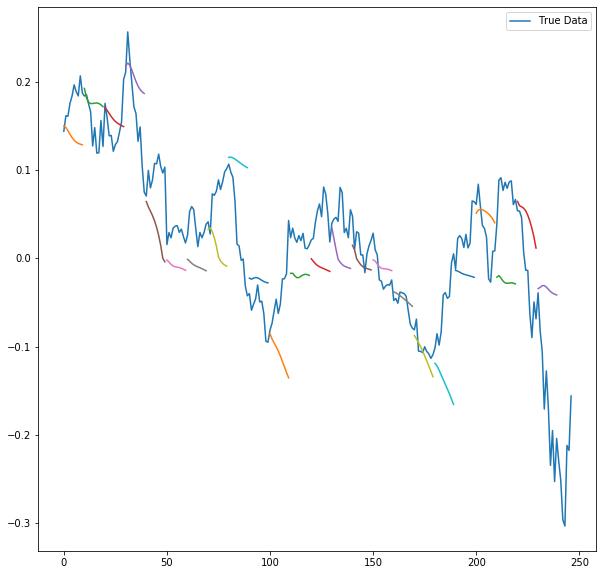

In [166]:
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
plot_results_multiple(predictions, y_test, 10) 
#10 day prediction with 50 day sequence length 25 epochs
#hidden layers 10,20

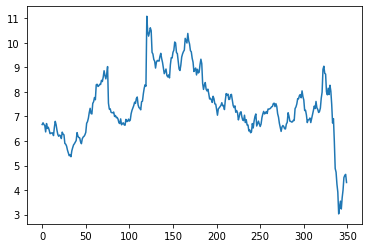

In [129]:
raw_df = pd.read_csv("../Stock_CSV/ZIXI.csv")
raw_seq = raw_df["4. close"]
seq = [ele for ele in reversed(raw_seq)] 
seq = np.array(seq)
seq.shape
plt.plot(seq[4682:])

In [13]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [316]:
def build_model1(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.3))
    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.3))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [313]:
seq_length = 100

In [314]:
model = build_model1(seq_length)

In [315]:
epochs = 5
#stock_list = set_stock_list()
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO']
for stock in stock_list:
    print(stock)
    try:
        x_train,x_test,y_train,y_test = set_data(stock , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 128,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("no")
#10-15 is decent
#4-5 with 2 act layers is good


AMZN
Train on 4684 samples, validate on 247 samples
Epoch 1/5
4684/4684 [==============================] - 13s 3ms/step - loss: 0.0268 - val_loss: 0.0036
Epoch 2/5
4684/4684 [==============================] - 28s 6ms/step - loss: 0.0122 - val_loss: 0.0038
Epoch 3/5
4684/4684 [==============================] - 25s 5ms/step - loss: 0.0102 - val_loss: 0.0028
Epoch 4/5
4684/4684 [==============================] - 37s 8ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 5/5
4684/4684 [==============================] - 35s 8ms/step - loss: 0.0088 - val_loss: 0.0023
MSFT
Train on 4684 samples, validate on 247 samples
Epoch 1/5
4684/4684 [==============================] - 34s 7ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 2/5
4684/4684 [==============================] - 33s 7ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/5
4684/4684 [==============================] - 33s 7ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 4/5
4684/4684 [==============================] - 29s 6ms/step - loss: 0.00

In [317]:
x_train, x_test, y_train,y_test = set_data('TCCO',seq_length)

In [318]:
predicted = predict_point_by_point(model, x_test)
mse(y_test,predicted)

0.047813678855789056

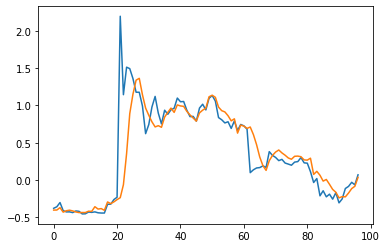

In [319]:
plt.plot(y_test[150:])
plt.plot(predicted[150:])


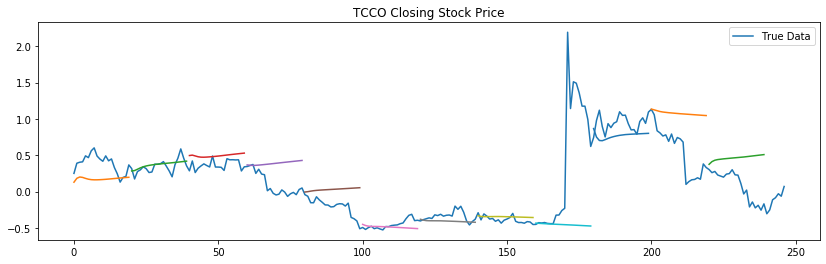

In [320]:
predictions = predict_sequences_multiple1(model, x_test, seq_length,20)
plot_results_multiple(predictions, y_test, 20, 'TCCO') 

0.0007572841728481416


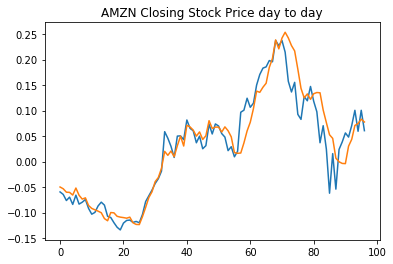

0.000959341468087251


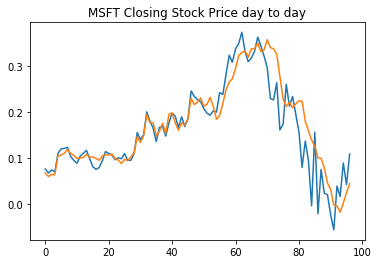

0.0008565538797574904


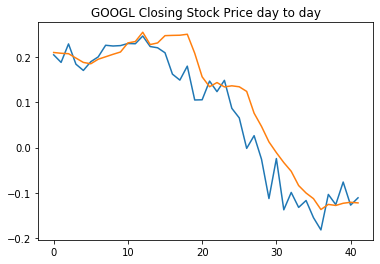

0.0011526126564940958


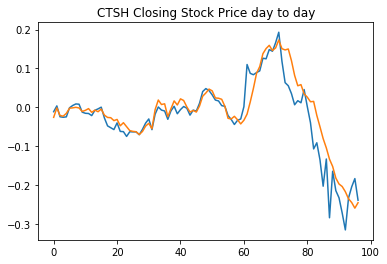

0.0018631193997848136


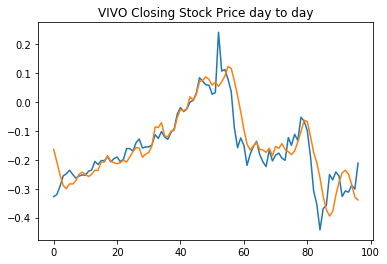

0.0009314984083845133


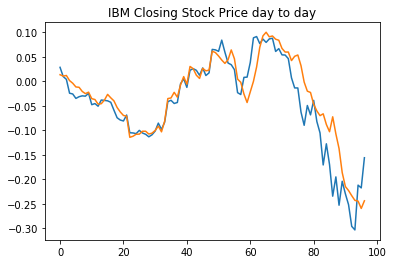

0.0009128204310964036


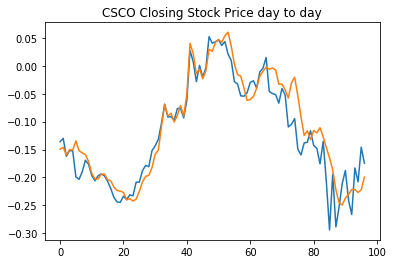

In [321]:
for stock in stock_list:
    x_train,x_test,y_train,y_test = set_data(stock , seq_length)
    predicted = predict_point_by_point(model, x_test)
    plt.plot(y_test[150:])
    plt.plot(predicted[150:])
    print(mse(y_test,predicted))
    plt.title(stock + " Closing Stock Price day to day")
    plt.show()

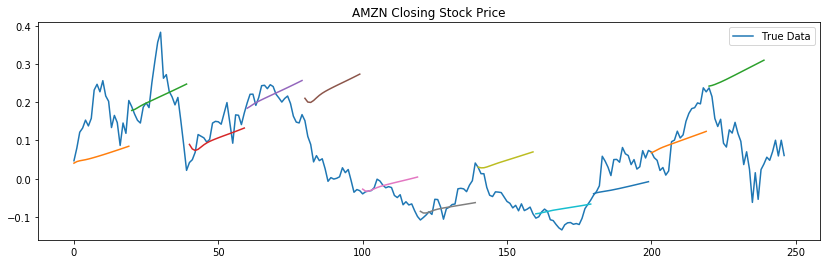

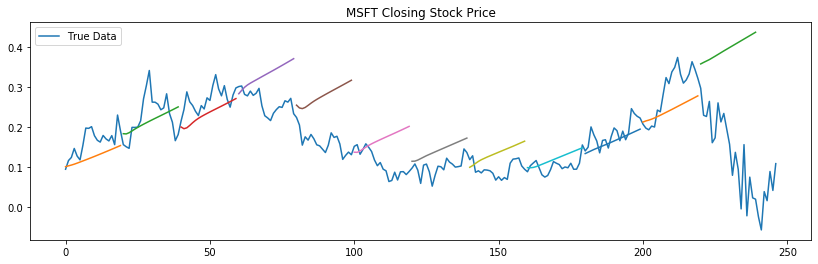

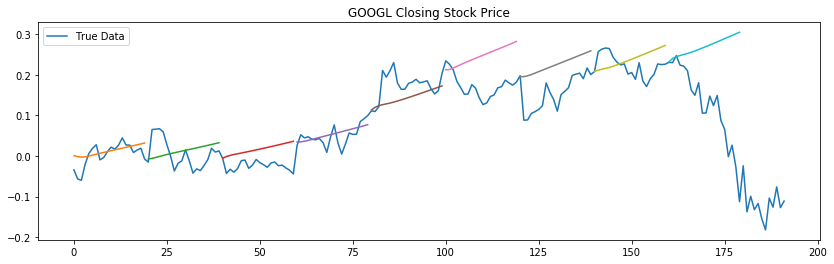

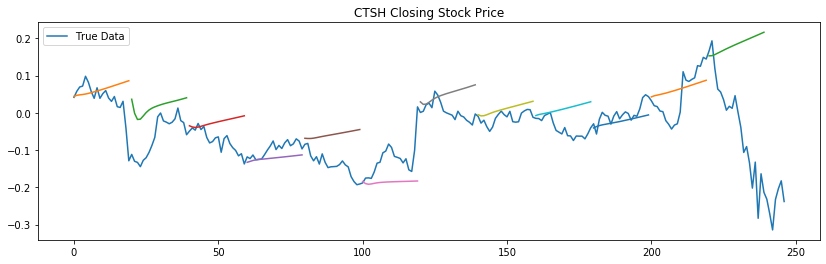

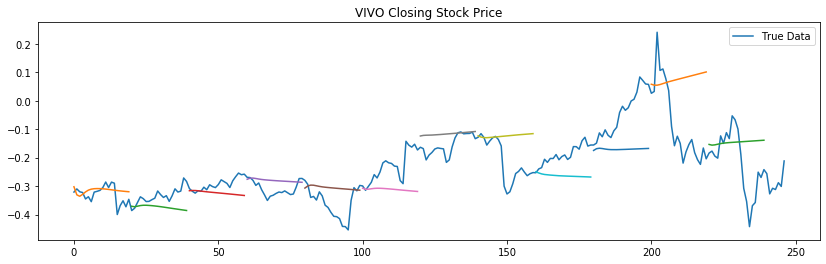

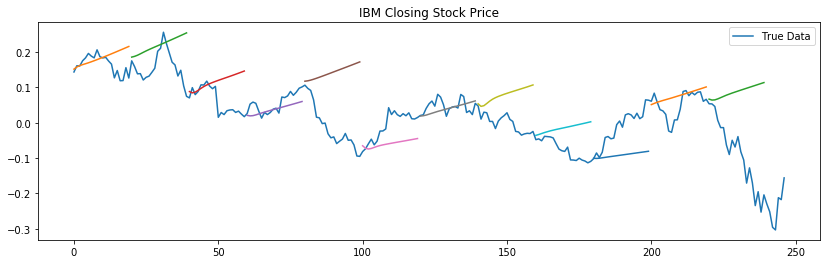

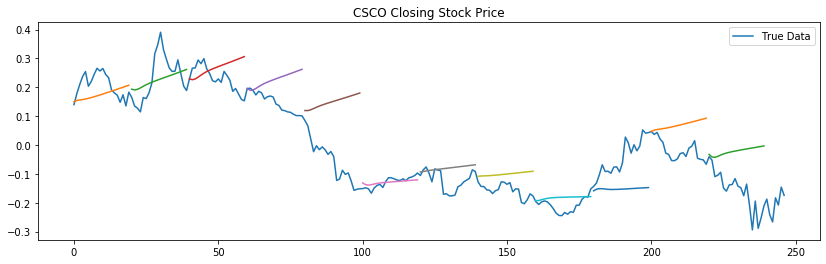

In [322]:
for stock in stock_list:
    x_train,x_test,y_train,y_test = set_data(stock , seq_length)
    predictions = predict_sequences_multiple1(model, x_test, seq_length,20)
    plot_results_multiple(predictions, y_test, 20, stock) 

In [323]:
model.save('stock_nn.h5')